Importing Libraries

In [1]:
#Date: 05/05/2021
#Location: Imaging Mind Architecture Lab, Trinity College Dublin

# Loading all the libraries

import os
from pathlib import Path

import glob
import numpy as np
import pandas as pd
from nilearn import signal
import seaborn as sns

from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold, isc

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn import preprocessing, decomposition, manifold

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import copy

%matplotlib inline


c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\nilearn\datasets\__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Setting Data Directory

In [2]:
# Data directory

# Path to data in my PC
path_ASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group_1_ASD\\*.txt'
path_Non_ASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group_2_Non_ASD\\*.txt'

# List of all the text files
sub_list_1 = [x for x in glob.iglob(path_ASD, recursive=True)]
print('Number of ASD participants:', len(sub_list_1))
sub_list_2 = [x for x in glob.iglob(path_Non_ASD, recursive=True)]
print('Number of Non-ASD participants:', len(sub_list_2))

# Initiating empty list for all time points
time_p_1 = []
time_p_2 = []

########################################################################################################################################

# Iterating over ROIs of each subject
for sub in sub_list_1:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a, b) = activation_values.shape
    time_p_1.append(a)

# Selecting the lowest value
time_dim_1 = min(time_p_1)

# Iterating over ROIs of each subject
for sub in sub_list_2:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a, b) = activation_values.shape
    time_p_2.append(a)

# Selecting the lowest value
time_dim_2 = min(time_p_2)

print('The minimum number of time points in ASD Cohort =', time_dim_1)
print('The minimum number of time points in Non-ASD Cohort =', time_dim_2)

Number of ASD participants: 29
Number of Non-ASD participants: 22
The minimum number of time points in ASD Cohort = 206
The minimum number of time points in Non-ASD Cohort = 206


Processing empty entries

In [6]:
# Processing data to remove all ROIs having zero value for BOLD activation (ASD)

# Initiating timeseries data as list
timeseries_3D_ASD = []

# All indices having zero value
zeroes_ASD = []

# Iterating over ROIs of each subject
for sub in sub_list_1:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis=0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)

    zeroes_ASD.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D_ASD.append(activation_values[0:time_dim_1, :])

# Converting timeseries data in numpy array
timeseries_3D_ASD = np.asarray(timeseries_3D_ASD)

# Unique zero values for all ROIs
zeroes_ASD = np.unique(zeroes_ASD).astype(int)

# Removing ROIs having zeroes
timeseries_3D_ASD = np.delete(timeseries_3D_ASD, zeroes_ASD, axis=2)

# Dimension check for the output
print('Dimensions of ASD dataset (Subjects, Timepoints, ROIs) =',timeseries_3D_ASD.shape)


Dimensions of ASD dataset (Subjects, Timepoints, ROIs) = (29, 206, 268)


In [7]:
# Processing data to remove all ROIs having zero value for BOLD activation (Non-ASD)

# Initiating timeseries data as list
timeseries_3D_Non_ASD = []

# All indices having zero value
zeroes_Non_ASD = []

# Iterating over ROIs of each subject
for sub in sub_list_2:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis=0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)

    zeroes_Non_ASD.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D_Non_ASD.append(activation_values[0:time_dim_2, :])

# Converting timeseries data in numpy array
timeseries_3D_Non_ASD = np.asarray(timeseries_3D_Non_ASD)

# Unique zero values for all ROIs
zeroes_Non_ASD = np.unique(zeroes_Non_ASD).astype(int)

# Removing ROIs having zeroes
timeseries_3D_Non_ASD = np.delete(timeseries_3D_Non_ASD, zeroes_Non_ASD, axis=2)

# Dimension check for the output
print('Dimensions of Non-ASD dataset (Subjects, Timepoints, ROIs) =', timeseries_3D_Non_ASD.shape)

Dimensions of Non-ASD dataset (Subjects, Timepoints, ROIs) = (22, 206, 268)


Standardising timeseries

In [8]:
# Standardising the timeseries by z-transforming

# Initialising standard timeseries dictionary
z_timeseries_ASD = {}
z_timeseries_Non_ASD = {}

# Using z-score to standardise each value
for sub in range(timeseries_3D_ASD.shape[0]):
    z_timeseries_ASD[sub] = signal.clean(timeseries_3D_ASD[sub, :, :], detrend=False, standardize='zscore', standardize_confounds=False, t_r=None)
    z_timeseries_ASD[sub] = pd.DataFrame(z_timeseries_ASD[sub])

for sub in range(timeseries_3D_Non_ASD.shape[0]):
    z_timeseries_Non_ASD[sub] = signal.clean(timeseries_3D_Non_ASD[sub, :, :], detrend=False, standardize='zscore', standardize_confounds=False, t_r=None)
    z_timeseries_Non_ASD[sub] = pd.DataFrame(z_timeseries_Non_ASD[sub])

print('Dimensions of each subject in ASD Cohort =', z_timeseries_ASD[sub].shape)
print('No. of subjects in ASD Cohort =', len(z_timeseries_ASD))

print('Dimensions of each subject in Non-ASD Cohort =', z_timeseries_Non_ASD[sub].shape)
print('No. of subjects in Non-ASD Cohort =', len(z_timeseries_Non_ASD))

Dimensions of each subject in ASD Cohort = (206, 268)
No. of subjects in ASD Cohort = 29
Dimensions of each subject in Non-ASD Cohort = (206, 268)
No. of subjects in Non-ASD Cohort = 22


In [9]:
# Converting standardised timeseries to 3D matrix

# Initiating empty list
std_3D_ASD = []
std_3D_Non_ASD = []

for sub in z_timeseries_ASD:
    std_3D_ASD.append(z_timeseries_ASD[sub])

for sub in z_timeseries_Non_ASD:
    std_3D_Non_ASD.append(z_timeseries_Non_ASD[sub])

std_3D_ASD = np.array(std_3D_ASD)
std_3D_Non_ASD = np.array(std_3D_Non_ASD)


Importing Shen 268 Mask

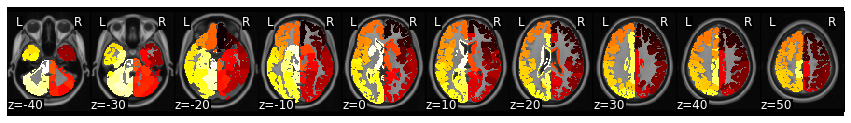

In [10]:
# Mask with 268 parcellations

# Importing mask from Neurovault
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

Calculating Similarity Matrix

In [11]:
# Defining parameters

ASD_n_subs, ASD_n_ts, ASD_n_nodes = std_3D_ASD.shape
Non_ASD_n_subs, Non_ASD_n_ts, Non_ASD_n_nodes = std_3D_Non_ASD.shape

In [8]:
# Similarity Matrices for ASD using adjacency

ASD_similarity_matrices = []

for node in range(ASD_n_nodes):
    ASD_similarity_matrices.append(Adjacency(1 - pairwise_distances(std_3D_ASD[:, :, node], metric='correlation'), matrix_type='similarity'))

ASD_similarity_matrices = Adjacency(ASD_similarity_matrices)

# # Plot to check
# ASD_similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')

In [9]:
# Similarity Matrices for Non-ASD using adjacency

Non_ASD_similarity_matrices = []

for node in range(Non_ASD_n_nodes):
    Non_ASD_similarity_matrices.append(Adjacency(1 - pairwise_distances(std_3D_Non_ASD[:, :, node], metric='correlation'), matrix_type='similarity'))

Non_ASD_similarity_matrices = Adjacency(Non_ASD_similarity_matrices)
# # Plotting to check
# Non_ASD_similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')


Calculating per participant ISC

In [10]:
# Calculating per participant ISC

# For ASD Cohort
ASD_corr_mat = np.array(ASD_similarity_matrices.squareform())
ASD_mod_corr = np.where(ASD_corr_mat == 0, np.nan, ASD_corr_mat)
ASD_avg_corr = np.nanmean(ASD_mod_corr, axis=2)
ASD_part_ISC = np.mean(ASD_avg_corr, axis=0) # To plot per participant Mean ISC

# For Non-ASD Cohort
Non_ASD_corr_mat = np.array(Non_ASD_similarity_matrices.squareform())
Non_ASD_mod_corr = np.where(Non_ASD_corr_mat == 0, np.nan, Non_ASD_corr_mat)
Non_ASD_avg_corr = np.nanmean(Non_ASD_mod_corr, axis=2)
Non_ASD_part_ISC = np.mean(Non_ASD_avg_corr, axis=0) # To plot per participant Mean ISC


In [11]:
# Function to generate swarm plot

def swarm(array1, array2, label):
    dataf = pd.DataFrame()
    dataf['ASD'] = pd.Series(array1)
    dataf['Non-ASD'] = pd.Series(array2)
    # Plotting array values
    plot1 = sns.barplot(data=dataf, dodge=True, capsize=.05, errcolor='.25', errwidth=2, palette='Set2')
    plot1 = sns.swarmplot(data=dataf, palette='Set1', size=3)
    plot1.set_ylabel(f'{label}')
    plot1 = plt.show()


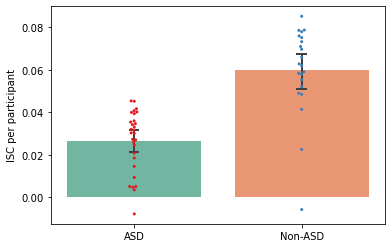

In [12]:
# Swarm plot for ISC values per participant

swarm(ASD_part_ISC, Non_ASD_part_ISC, 'ISC per participant')


Yeo7 Network and Analysis

In [13]:
# Yeo 7 Network

# Reading Yeo 7 csv file
yeo7 = pd.read_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\Templates and Inputs\\shen_268_parcellation_networklabels[84497].csv')

# Initiating the empty dictionary
network = {}

# Zipping 2 columns in the file
z_list = list(zip(yeo7['Network'], yeo7['Node']))

for a, b in z_list:
    if a not in network:
        network[a] = []
    if a in network:
        network[a].append(b)

# Sanity check for all the assignment of all values
sum = 0

for i in network:
    count = len(network[i])
    print ('Network', i, ', No. of regions =', count)
    sum = sum+count

print ('Number of items sorted in keys =', sum)

Network 2 , No. of regions = 34
Network 4 , No. of regions = 90
Network 3 , No. of regions = 20
Network 1 , No. of regions = 29
Network 5 , No. of regions = 50
Network 8 , No. of regions = 18
Network 6 , No. of regions = 18
Network 7 , No. of regions = 9
Number of items sorted in keys = 268


In [14]:
# Dictionary of ROI correlations for each participant

ASD_roi_isc_pp = {}
Non_ASD_roi_isc_pp = {}

for i in range(len(ASD_avg_corr)):
    ASD_roi_isc_pp[i] = ASD_avg_corr[i]
    Non_ASD_roi_isc_pp[i] = Non_ASD_avg_corr[i]

In [15]:
# Dictionary of Networkwise Mean ISC values

ASD_network_isc = {}
Non_ASD_network_isc = {}

sanity_count = 0

for j in network:
    # print (f'Number of entries in key {j}: {len(network[j])}')
    ASD_temp = []
    Non_ASD_temp = []
    for keys in network[j]:
        ASD_temp.append(ASD_roi_isc_pp[keys-1])
        Non_ASD_temp.append(Non_ASD_roi_isc_pp[keys-1])
    ASD_network_isc[j] = ASD_temp
    Non_ASD_network_isc[j] = Non_ASD_temp

    if len(network[j]) == len(ASD_network_isc[j]) & len(network[j]) == len(Non_ASD_network_isc[j]):
        sanity_count = sanity_count+1

    # Converting key type from list to numpy array
    ASD_network_isc[j] = np.array(ASD_network_isc[j])
    ASD_network_isc[j] = np.mean(ASD_network_isc[j], axis=0)
    Non_ASD_network_isc[j] = np.array(Non_ASD_network_isc[j])
    Non_ASD_network_isc[j] = np.mean(Non_ASD_network_isc[j], axis=0)

print(f'Number of sorted networks: {sanity_count}')

Number of sorted networks: 8


Cohort Comparison

SW test statistic for ASD Cohort is 0.9176684021949768
p-value for SW test for ASD Cohort is 0.02662481926381588
Mean ISC values for ASD cohort do not follow Gaussian distribution


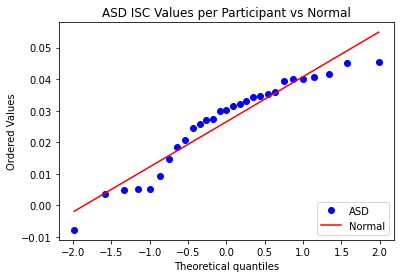

SW test statistic for ASD Cohort is 0.8537441492080688
p-value for SW test for ASD Cohort is 0.003956637345254421
Mean ISC values for Non-ASD cohort do not follow Gaussian distribution


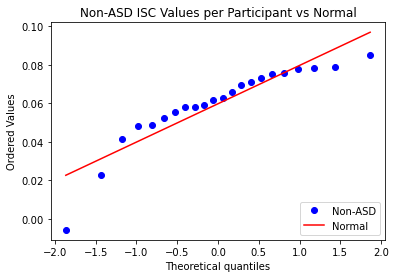

In [16]:
# Shapiro-Wilk Test for Normality

# ASD Cohort
sw_test_ind_ASD, sw_p_ind_ASD = stats.shapiro(ASD_part_ISC)
print('SW test statistic for ASD Cohort is', sw_test_ind_ASD)
print('p-value for SW test for ASD Cohort is', sw_p_ind_ASD)

if sw_p_ind_ASD > 0.05:
    print('Mean ISC values for ASD cohort follow Gaussian distribution')
else:
    print('Mean ISC values for ASD cohort do not follow Gaussian distribution')

# Q-Q plot
stats.probplot(ASD_part_ISC, dist='norm', plot=plt)
plt.title('ASD ISC Values per Participant vs Normal')
plt.legend(["ASD", "Normal"], loc="lower right")
plt.show()

# Non-ASD Cohort
sw_test_ind_non_ASD, sw_p_ind_non_ASD = stats.shapiro(Non_ASD_part_ISC)
print('SW test statistic for ASD Cohort is', sw_test_ind_non_ASD)
print('p-value for SW test for ASD Cohort is', sw_p_ind_non_ASD)

if sw_p_ind_non_ASD > 0.05:
    print('Mean ISC values for Non-ASD cohort follow Gaussian distribution')
else:
    print('Mean ISC values for Non-ASD cohort do not follow Gaussian distribution')

# Q-Q plot
stats.probplot(Non_ASD_part_ISC, dist='norm', plot=plt)
plt.title('Non-ASD ISC Values per Participant vs Normal')
plt.legend(["Non-ASD", "Normal"], loc="lower right")
plt.show()


In [17]:
# Mann-Whitney U test

print('Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation')

mn_stats_pp, p_value_pp = stats.mannwhitneyu(ASD_part_ISC, Non_ASD_part_ISC, alternative='two-sided')
print('MN test statistic is', mn_stats_pp)
print('p-value for MN test is', p_value_pp)

if p_value_pp <= 0.05:
    print('Null hypothesis is rejected, hence ASD group != Non-ASD group')
else:
    print('Null hypothesis is retained, hence ASD group = Non-ASD group')


Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 51.0
p-value for MN test is 3.628597339716713e-07
Null hypothesis is rejected, hence ASD group != Non-ASD group


Network-wise Comparison per Cohort

In [15]:
# Function for test of normality and comparison

# Helper Function

# Shapiro Test
def shapiro(arr, label):
    sw_test, sw_p = stats.shapiro(arr)
    print(f'SW test statistic for {label} is {sw_test}')
    print(f'p-value for {label} is {sw_p}')
    return sw_test, sw_p

# Q-Q plot
def qqplot(arr, label):
    stats.probplot(arr, dist='norm', plot=plt)
    plt.title(f'{label} vs Normal')
    plt.legend([f'{label}', "Normal"], loc="lower right")
    plt.show()

# Major Function (Array1 = ASD Data, Array2 = Non-ASD Data, Label = 'Network')
def compare(array1, array2, label):

    swarm(array1, array2, 'Comparison of '+label+' Network')

    # ASD Cohort (array1)
    _, sw_p_ASD = shapiro(array1, label)
    if sw_p_ASD > 0.05:
        print('Values for ASD cohort follow Gaussian distribution')
    else:
        print('Values for ASD cohort do not follow Gaussian distribution')
    qqplot(array1, label+' (ASD)')

    # Non-ASD Cohort (array2)
    _, sw_p_nASD = shapiro(array2, label)
    if sw_p_nASD > 0.05:
        print('Values for Non-ASD cohort follow Gaussian distribution')
    else:
        print('Values for Non-ASD cohort do not follow Gaussian distribution')
    qqplot(array2, label+' (Non-ASD)')

    if sw_p_ASD > 0.05 and sw_p_nASD > 0.05:
        print('Running t-test...')
        # t-Test
        print('Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation')
        t_value, t_p_value = stats.ttest_ind(array2, array1)
        print('Test statistic is', t_value)
        print('p-value for two tailed test is', t_p_value)

        if t_p_value <= 0.05:
            print('Null hypothesis is rejected, hence ASD group != Non-ASD group')
        else:
            print('Null hypothesis is retained, hence ASD group = Non-ASD group')
    else:
        print('Running Mann-Whitney U test...')
        # Mann-Whitney U test
        print('Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation')
        mn_stats, mn_p_value = stats.mannwhitneyu(
            array1, array2, alternative='two-sided')
        print('MN test statistic is', mn_stats)
        print('p-value for MN test is', mn_p_value)
        if mn_p_value <= 0.05:
            print('Null hypothesis is rejected, hence ASD group != Non-ASD group')
        else:
            print('Null hypothesis is retained, hence ASD group = Non-ASD group')


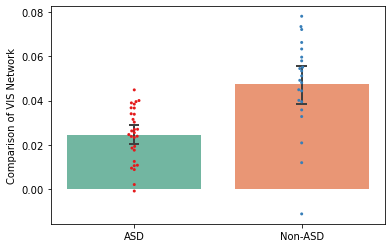

SW test statistic for VIS is 0.9633002281188965
p-value for VIS is 0.3952246606349945
Values for ASD cohort follow Gaussian distribution


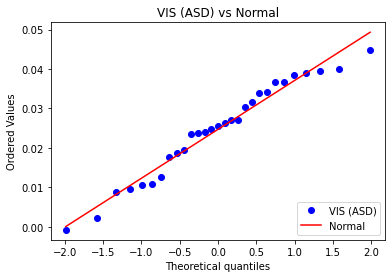

SW test statistic for VIS is 0.9321392178535461
p-value for VIS is 0.13595430552959442
Values for Non-ASD cohort follow Gaussian distribution


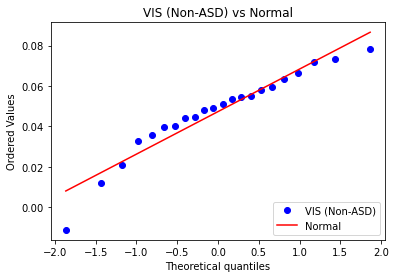

Running t-test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
Test statistic is 4.874928656141735
p-value for two tailed test is 1.1863640661906353e-05
Null hypothesis is rejected, hence ASD group != Non-ASD group


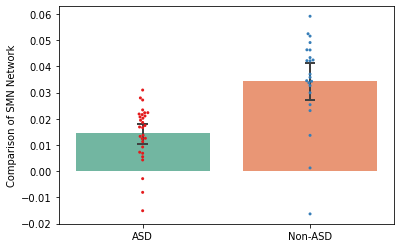

SW test statistic for SMN is 0.9280654191970825
p-value for SMN is 0.04902910068631172
Values for ASD cohort do not follow Gaussian distribution


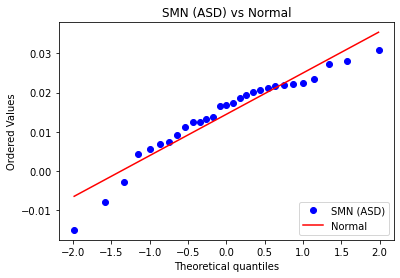

SW test statistic for SMN is 0.8858669996261597
p-value for SMN is 0.01566356047987938
Values for Non-ASD cohort do not follow Gaussian distribution


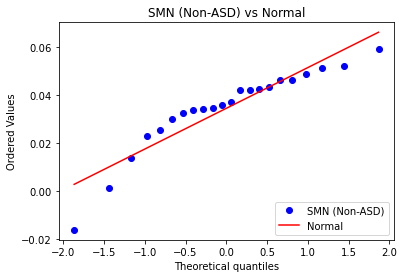

Running Mann-Whitney U test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 80.0
p-value for MN test is 5.734835187141054e-06
Null hypothesis is rejected, hence ASD group != Non-ASD group


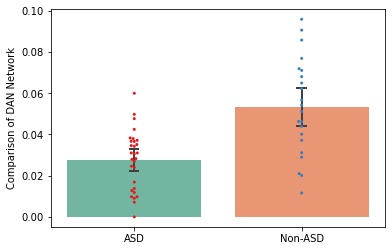

SW test statistic for DAN is 0.968364953994751
p-value for DAN is 0.5162285566329956
Values for ASD cohort follow Gaussian distribution


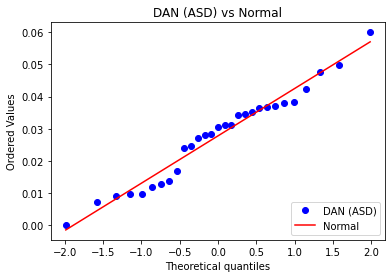

SW test statistic for DAN is 0.9816678762435913
p-value for DAN is 0.9400486350059509
Values for Non-ASD cohort follow Gaussian distribution


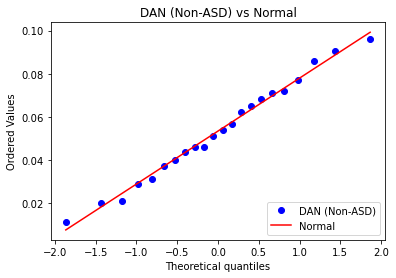

Running t-test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
Test statistic is 4.8291336919879555
p-value for two tailed test is 1.3863918315827424e-05
Null hypothesis is rejected, hence ASD group != Non-ASD group


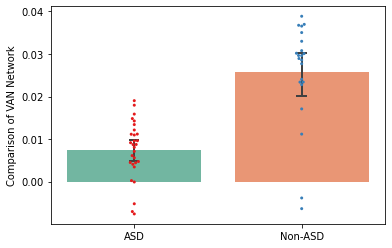

SW test statistic for VAN is 0.9586067199707031
p-value for VAN is 0.30360835790634155
Values for ASD cohort follow Gaussian distribution


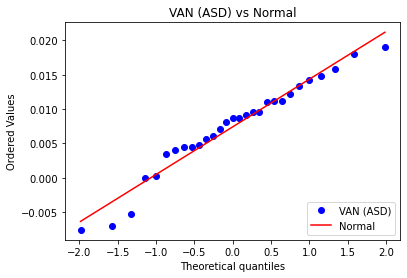

SW test statistic for VAN is 0.8154639005661011
p-value for VAN is 0.0008825096883811057
Values for Non-ASD cohort do not follow Gaussian distribution


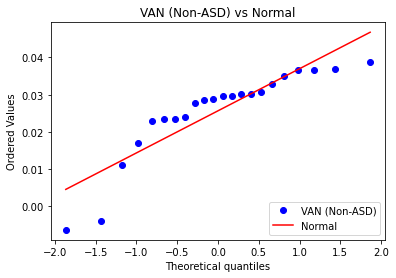

Running Mann-Whitney U test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 63.0
p-value for MN test is 1.1782944998577831e-06
Null hypothesis is rejected, hence ASD group != Non-ASD group


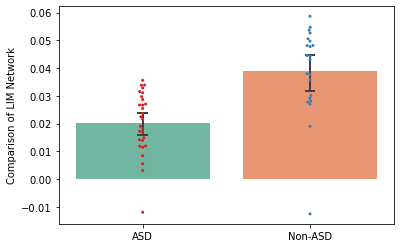

SW test statistic for LIM is 0.9433026313781738
p-value for LIM is 0.12237388640642166
Values for ASD cohort follow Gaussian distribution


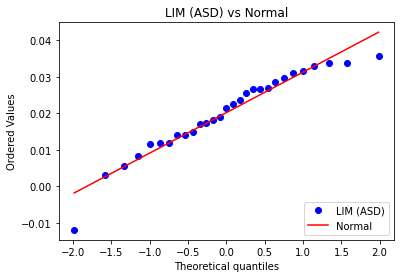

SW test statistic for LIM is 0.8595868945121765
p-value for LIM is 0.005039880517870188
Values for Non-ASD cohort do not follow Gaussian distribution


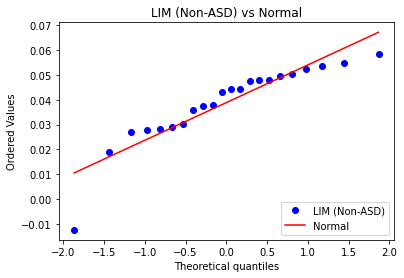

Running Mann-Whitney U test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 83.0
p-value for MN test is 7.503534882313026e-06
Null hypothesis is rejected, hence ASD group != Non-ASD group


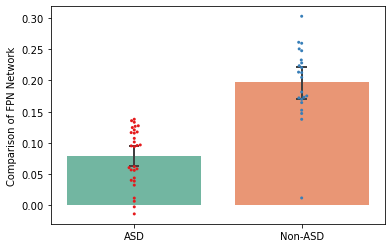

SW test statistic for FPN is 0.9208947420120239
p-value for FPN is 0.03212743625044823
Values for ASD cohort do not follow Gaussian distribution


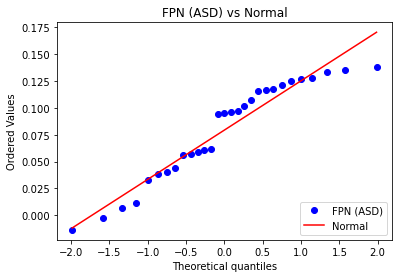

SW test statistic for FPN is 0.9121067523956299
p-value for FPN is 0.05227622762322426
Values for Non-ASD cohort follow Gaussian distribution


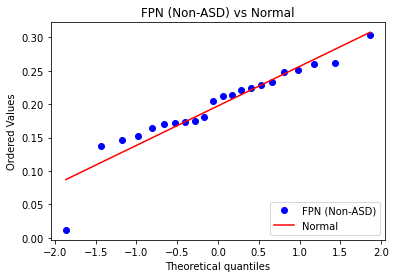

Running Mann-Whitney U test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 26.0
p-value for MN test is 2.6526504206301704e-08
Null hypothesis is rejected, hence ASD group != Non-ASD group


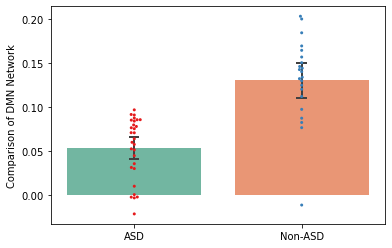

SW test statistic for DMN is 0.8901814222335815
p-value for DMN is 0.00574727077037096
Values for ASD cohort do not follow Gaussian distribution


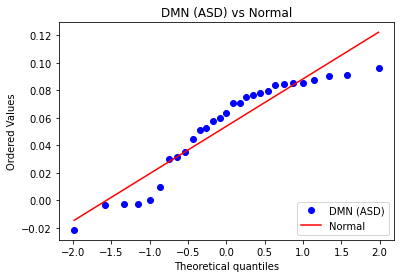

SW test statistic for DMN is 0.9194653630256653
p-value for DMN is 0.07410559058189392
Values for Non-ASD cohort follow Gaussian distribution


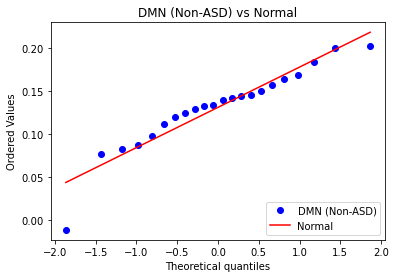

Running Mann-Whitney U test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 50.0
p-value for MN test is 3.281894767018011e-07
Null hypothesis is rejected, hence ASD group != Non-ASD group


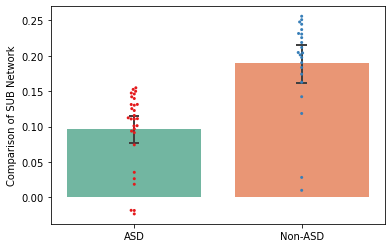

SW test statistic for SUB is 0.8383820652961731
p-value for SUB is 0.0004427474632393569
Values for ASD cohort do not follow Gaussian distribution


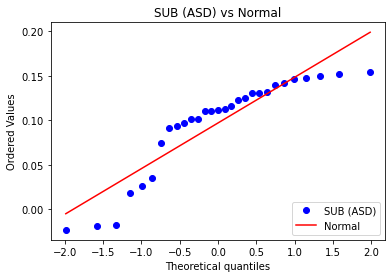

SW test statistic for SUB is 0.808790922164917
p-value for SUB is 0.0006890672375448048
Values for Non-ASD cohort do not follow Gaussian distribution


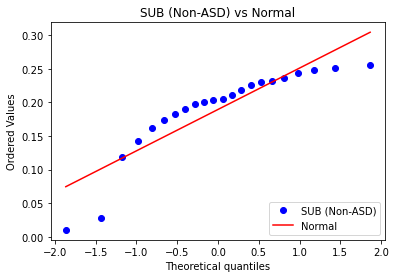

Running Mann-Whitney U test...
Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 67.0
p-value for MN test is 1.725446489042475e-06
Null hypothesis is rejected, hence ASD group != Non-ASD group


In [29]:
# Running analysis

Net_list = ['VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN', 'SUB']

for net, name in enumerate(Net_list):
    compare(ASD_network_isc[net+1], Non_ASD_network_isc[net+1], name)

Calculating ISC Values per ROI

In [13]:
# Calculating ISC for ASD and Non-ASD

# Intialising isc and p-value dictionaries
ASD_isc_r, ASD_isc_p = {}, {}
Non_ASD_isc_r, Non_ASD_isc_p = {}, {}

# Looping over all ROIs
for anode in range(ASD_n_nodes):
    astats = ASD_similarity_matrices[anode].isc(metric='median', n_bootstraps=10000, n_jobs=-1)
    ASD_isc_r[anode], ASD_isc_p[anode] = astats['isc'], astats['p']

for bnode in range(Non_ASD_n_nodes):
    bstats = Non_ASD_similarity_matrices[bnode].isc(metric='median', n_bootstraps=10000, n_jobs=-1)
    Non_ASD_isc_r[bnode], Non_ASD_isc_p[bnode] = bstats['isc'], bstats['p']

# Converting correlation and p-value back into a Brain_Data instance
ASD_isc_r_brain, ASD_isc_p_brain = roi_to_brain(pd.Series(ASD_isc_r), mask_x), roi_to_brain(pd.Series(ASD_isc_p), mask_x)
Non_ASD_isc_r_brain, Non_ASD_isc_p_brain = roi_to_brain(pd.Series(Non_ASD_isc_r), mask_x), roi_to_brain(pd.Series(Non_ASD_isc_p), mask_x)


In [17]:
# Number of significant regions after thresholding

# List of ROIs
# Using 1 to 269 instead of 268 because the reference Yeo 7 network csv labels parcel from 1, not 0
rois = [x for x in range(1, 269)]

# Significant ROIS
ASD_sig_roi = pd.Series(ASD_isc_p).values <= fdr(pd.Series(ASD_isc_p).values)
ASD_total_sig_roi = np.sum(ASD_sig_roi)
ASD_r_list = list(zip(rois, ASD_sig_roi))

ASD_sig_rois = []
ASD_corr_p = []
ASD_corr_isc = []

for a, b in ASD_r_list:
    if b == True:
        ASD_sig_rois.append(a)
        ASD_corr_p.append(ASD_isc_p[a-1])
        ASD_corr_isc.append(ASD_isc_r[a-1])

Non_ASD_sig_roi = pd.Series(Non_ASD_isc_p).values <= fdr(pd.Series(Non_ASD_isc_p).values)
Non_ASD_total_sig_roi = np.sum(Non_ASD_sig_roi)
Non_ASD_r_list = list(zip(rois, Non_ASD_sig_roi))

Non_ASD_sig_rois = []
Non_ASD_corr_p = []
Non_ASD_corr_isc = []

for c, d in Non_ASD_r_list:
    if d == True:
        Non_ASD_sig_rois.append(c)
        Non_ASD_corr_p.append(Non_ASD_isc_p[c-1])
        Non_ASD_corr_isc.append(Non_ASD_isc_r[c-1])

# print ('Significant ROIs =', sig_rois)
print('Number of significant parcels in ASD Cohort =', ASD_total_sig_roi)
print('Number of significant parcels in Non-ASD Cohort =', Non_ASD_total_sig_roi)


Number of significant parcels in ASD Cohort = 58
Number of significant parcels in Non-ASD Cohort = 75


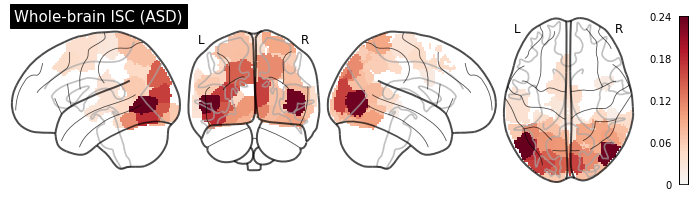

In [18]:
#Plotting ASD ISC map

plot_glass_brain(threshold(ASD_isc_r_brain, ASD_isc_p_brain, thr=fdr(pd.Series(ASD_isc_p).values)).to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='Whole-brain ISC (ASD)')


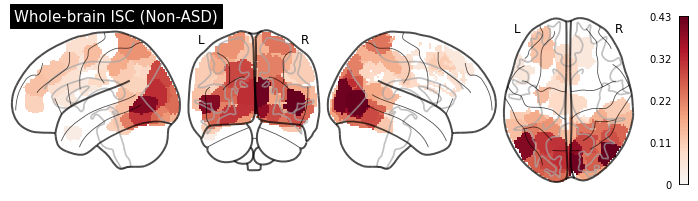

In [19]:
#Plotting ASD ISC map

plot_glass_brain(threshold(Non_ASD_isc_r_brain, Non_ASD_isc_p_brain, thr=fdr(pd.Series(Non_ASD_isc_p).values)).to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='Whole-brain ISC (Non-ASD)')


Network Level Analysis (per ROI)

In [21]:
# Number of significant regions in Yeo Network

# Dict of names of Yeo7 network
yeo7_net = {1: 'VIS', 2: 'SMN', 3: 'DAN', 4: 'VAN', 5: 'LIM', 6: 'FPN', 7: 'DMN', 8: 'SUB'}

# Making a copy of original network
ASD_sig_network = copy.deepcopy(network)
Non_ASD_sig_network = copy.deepcopy(network)

# Inititating count (Optional)
ASD_summ = 0
Non_ASD_summ = 0

# List of number of parcels in each network
ASD_count = []
ASD_n_num = []
Non_ASD_count = []
Non_ASD_n_num = []

# Iterating over each entry
for i in network:
    # Subset of common values
    ASD_sig_network[i] = set(network[i]) & set(ASD_sig_rois)
    Non_ASD_sig_network[i] = set(network[i]) & set(Non_ASD_sig_rois)
    # Counting of parcels in each network (Optional)
    ASD_countt = len(ASD_sig_network[i])
    Non_ASD_countt = len(Non_ASD_sig_network[i])
    ASD_count.append(ASD_countt)
    Non_ASD_count.append(Non_ASD_countt)
    ASD_n_num.append(yeo7_net[i])
    Non_ASD_n_num.append(yeo7_net[i])
    # print('Network', i, ', No. of regions =', countt)
    ASD_summ = ASD_summ+ASD_countt
    Non_ASD_summ = Non_ASD_summ+Non_ASD_countt

# List of significant parcels in each network
ASD_count = list(zip(ASD_n_num, ASD_count))
Non_ASD_count = list(zip(Non_ASD_n_num, Non_ASD_count))

# Sanity check
print('Number of items sorted in keys (for ASD) =', ASD_summ)
print('Number of items sorted in keys (for Non-ASD) =', Non_ASD_summ)


Number of items sorted in keys (for ASD) = 58
Number of items sorted in keys (for Non-ASD) = 75


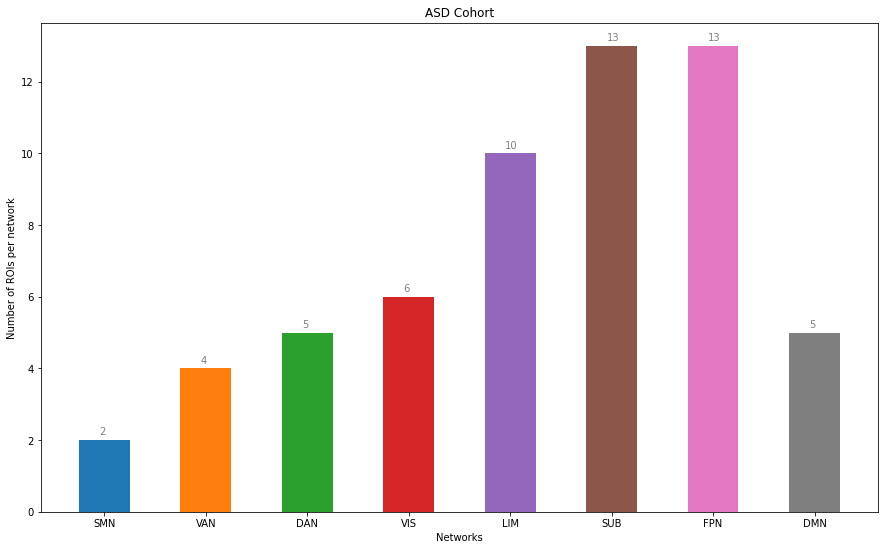

In [22]:
# Plotting number of Yeo7 Network areas for ASD

fig, ax = plt.subplots(figsize=(15, 9))


for a, b in ASD_count:
    ax.bar(a, b, width=0.5)

ax.set_title('ASD Cohort')
ax.set_ylabel('Number of ROIs per network')
ax.set_xlabel('Networks')

for i in ax.patches:
    plt.text(i.get_x()+0.2, i.get_height()+0.15,str(round((i.get_height()), 2)), fontsize=10, color='grey')


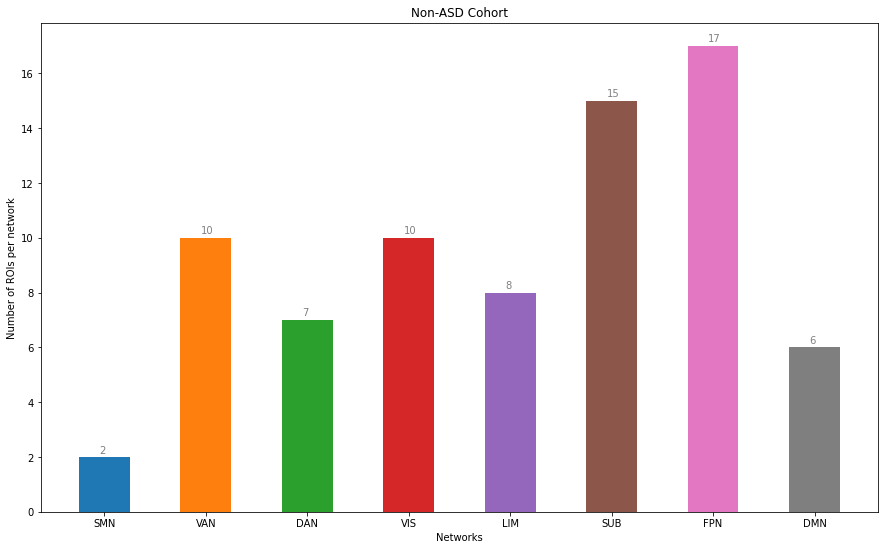

In [23]:
# Plotting number of Yeo7 Network areas for Non-ASD

fig, ax = plt.subplots(figsize=(15, 9))


for a, b in Non_ASD_count:
    ax.bar(a, b, width=0.5)

ax.set_title('Non-ASD Cohort')
ax.set_ylabel('Number of ROIs per network')
ax.set_xlabel('Networks')

for i in ax.patches:
    plt.text(i.get_x()+0.2, i.get_height()+0.15, str(round((i.get_height()), 2)), fontsize=10, color='grey')


In [24]:
# Sorting the network IDs in list

# Initiating empty list for network
ASD_net = []
ASD_temp = []
Non_ASD_net = []
Non_ASD_temp = []

for i in network.items():
    for j in ASD_sig_rois:
        if j in i[1]:
            ASD_net.append(i[0])
            ASD_temp.append(j)

for i in network.items():
    for j in Non_ASD_sig_rois:
        if j in i[1]:
            Non_ASD_net.append(i[0])
            Non_ASD_temp.append(j)

# Sorting the list
ASD_net = sorted(list(zip(ASD_temp, ASD_net)), key=lambda x: x[0])
Non_ASD_net = sorted(list(zip(Non_ASD_temp, Non_ASD_net)), key=lambda x: x[0])

ASD_new_net = []
Non_ASD_new_net = []

for a, b in ASD_net:
    ASD_new_net.append(b)
for a, b in Non_ASD_net:
    Non_ASD_new_net.append(b)

Exporting the ISC per ROI results

In [26]:
# Saving significant ISC values to a CSV file

# For ASD Cohort
ASD_sig_isc_val = pd.DataFrame()
ASD_sig_isc_val['ROI'] = ASD_sig_rois
ASD_sig_isc_val['ISC'] = ASD_corr_isc
ASD_sig_isc_val['p'] = ASD_corr_p
ASD_sig_isc_val['Network'] = ASD_new_net
ASD_sig_isc_val.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\Run_2_ASD_ISC_per_ROI.csv', index=False)

# For ASD Cohort
Non_ASD_sig_isc_val = pd.DataFrame()
Non_ASD_sig_isc_val['ROI'] = Non_ASD_sig_rois
Non_ASD_sig_isc_val['ISC'] = Non_ASD_corr_isc
Non_ASD_sig_isc_val['p'] = Non_ASD_corr_p
Non_ASD_sig_isc_val['Network'] = Non_ASD_new_net
Non_ASD_sig_isc_val.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Run_2_Non_ASD_ISC_per_ROI.csv', index=False)


In [28]:
# Saving ISC values to a CSV file

# For ASD Cohort
ASD_all_isc = pd.DataFrame()
ASD_all_isc['ISC_R'] = ASD_isc_r.values()
ASD_all_isc['ISC_p'] = ASD_isc_p.values()
ASD_all_isc.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\Run_2_ASD_ISC_Results_All_Values.csv', index=False)

# For Non-ASD Cohort
# For ASD Cohort
Non_ASD_all_isc = pd.DataFrame()
Non_ASD_all_isc['ISC_R'] = Non_ASD_isc_r.values()
Non_ASD_all_isc['ISC_p'] = Non_ASD_isc_p.values()
Non_ASD_all_isc.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Run_2_Non_ASD_ISC_Results_All_Values.csv', index=False)


In [29]:
# Exporting nifti file (ISC)

ASD_ISC_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\Run_2_ASD_ISC_per_ROI.nii.gz'
Non_ASD_ISC_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Run_2_Non_ASD_ISC_per_ROI.nii.gz'

threshold(ASD_isc_r_brain, ASD_isc_p_brain, thr=fdr(pd.Series(ASD_isc_p).values)).write(ASD_ISC_file)
threshold(Non_ASD_isc_r_brain, Non_ASD_isc_p_brain, thr=fdr(pd.Series(Non_ASD_isc_p).values)).write(Non_ASD_ISC_file)


Group classification using selected Behaviour Score

In [13]:
# Data Directory

# Path to data in my PC
path = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\Templates and Inputs\\Data.xlsx'

dem_data = pd.read_excel(path)

# Participants
participants = dem_data['ID']

# Group labels (For easy plotting)
groups = dem_data['Group']

# Defining parameters
features_T1_SRS2 = np.array(['T1_SRS2_Awr', 'T1_SRS2_Cog', 'T1_SRS2_Com', 'T1_SRS2_Mot', 'T1_SRS2_RRB'])

# Group labels (For easy plotting)
groups.replace(1, 0, inplace=True)  # ASD Group
groups.replace(2, 1, inplace=True)  # Non-ASD Group


In [19]:
# Initialising using PCA

given_data_T1_SRS2 = dem_data.loc[:, features_T1_SRS2]

# Perform PCA (to visualise global structure)
pca = decomposition.PCA(n_components = 2)

In [20]:
# Explanation  of variance via PCA for T1_SRS2

# Initialising via pca for better seggregation of clusters for T1_SRS2
pca_init_T1_SRS2 = pca.fit_transform(given_data_T1_SRS2)
print('PCA Output Shape:', pca_init_T1_SRS2.shape)

# Dataframe of PCA components
pca_stats_T1_SRS2 = pd.DataFrame(columns=['PCA Component 1', 'PCA Component 2'])

pca_stats_T1_SRS2['PCA Component 1'] = pca_init_T1_SRS2[:, 0]
pca_stats_T1_SRS2['PCA Component 2'] = pca_init_T1_SRS2[:, 1]

# Inbuilt function to explain the variance by each component
print('T1_SRS2 Variance explained per principal component: {}'.format(pca.explained_variance_ratio_))


PCA Output Shape: (51, 2)
T1_SRS2 Variance explained per principal component: [0.8882691  0.05169419]


In [21]:
# t-SNE on standardised data (to visualise local structures)

tSNE_T1_SRS2 = manifold.TSNE(method='exact').fit_transform(given_data_T1_SRS2)  # method = 'exact', because the sample size in small

# t-SNE on PCA output (For better grouping, according to literature)
pca_tSNE_T1_SRS2 = manifold.TSNE(method='exact').fit_transform(pca_init_T1_SRS2)

In [22]:
# Function to visualize the outputs of PCA and t-SNE

def scatter(x, colors):

    # Selecting color palette
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # Generating scatter plot
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    # ax.axis('off')
    ax.axis('tight')

    # Adding the labels for each group
    txts = []
    g_label = ['ASD', 'Non-ASD']

    for i in range(num_classes):

        # Position of each label at median of data points

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(g_label[i]), fontsize=20)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(35.9093366799343, -1.0501822928319369, 'ASD'),
  Text(-38.66483619328519, 0.30401378655568423, 'Non-ASD')])

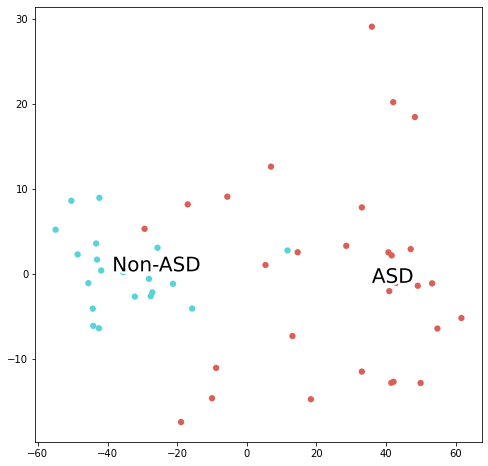

In [23]:
# Visualising PCA on T1_SRS2

components = pca_stats_T1_SRS2[['PCA Component 1', 'PCA Component 2']]

# Plotting scatter plot
scatter(components.values, groups)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-9.761303, -79.17812, 'ASD'), Text(4.088505, 93.21229, 'Non-ASD')])

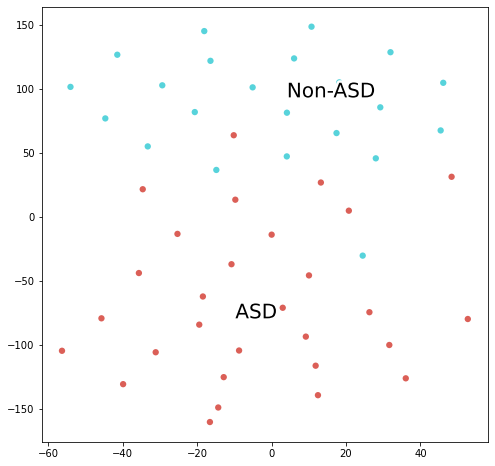

In [24]:
# Visualising t-SNE on standardised data of T1_SRS2

scatter(tSNE_T1_SRS2, groups)

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(-61.08117, 28.616482, 'ASD'), Text(71.25844, -42.774765, 'Non-ASD')])

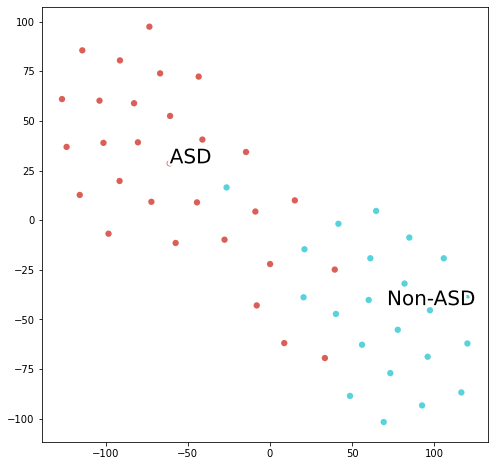

In [25]:
# Visualising t-SNE on data initialised by PCA on T1_SRS

scatter(pca_tSNE_T1_SRS2, groups)

Selecting Most Relevant Score

In [49]:
# Loading the desired data in the T1_SRS2 dataframe

classify_T1_SRS2 = pd.DataFrame()
classify_T1_SRS2['total'] = dem_data['T1_SRS2_Total']
classify_T1_SRS2['awr'] = dem_data['T1_SRS2_Awr']
classify_T1_SRS2['cog'] = dem_data['T1_SRS2_Cog']
classify_T1_SRS2['com'] = dem_data['T1_SRS2_Com']
classify_T1_SRS2['mot'] = dem_data['T1_SRS2_Mot']
classify_T1_SRS2['rrb'] = dem_data['T1_SRS2_RRB']
classify_T1_SRS2['target'] = groups

classify_T1_SRS2.head()

,total,awr,cog,com,mot,rrb,target
0,83,90,78,71,82,86,0
1,81,86,76,86,77,61,0
2,70,70,72,68,62,69,0
3,41,43,39,43,43,42,1
4,41,45,42,41,40,45,1


C:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


<AxesSubplot:>

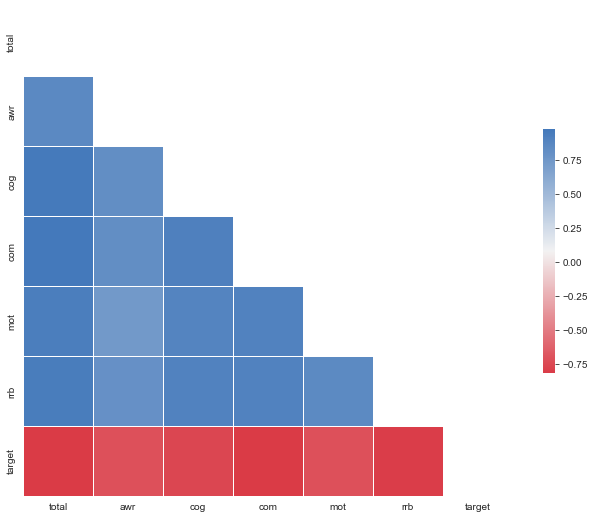

In [50]:
# Computing pairwise correlations for the dataframe T1_SRS2 features

corr = classify_T1_SRS2.corr()

# Visualising the data
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set_style(style='white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

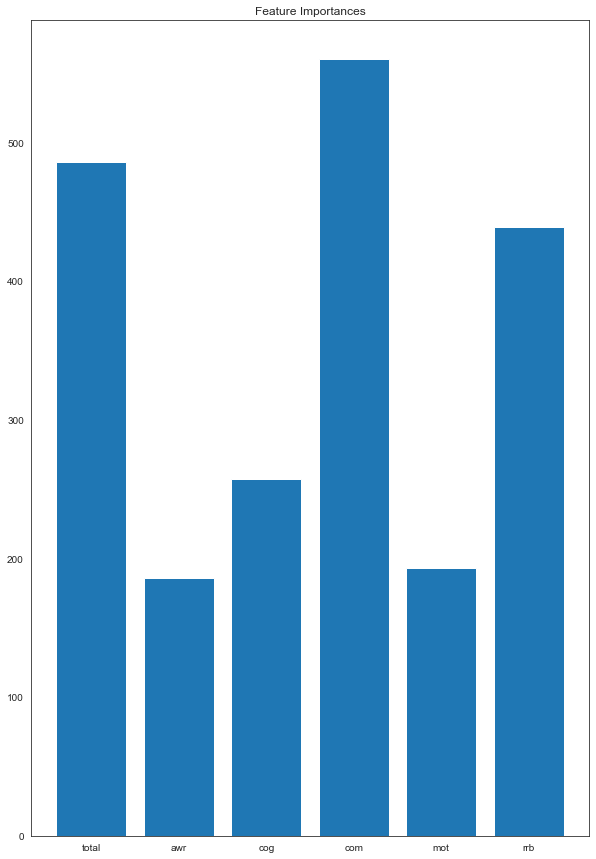

In [51]:
# Finding the most relevant feature in T1_SRS2

# Defining features
features_T1_SRS2 = classify_T1_SRS2.drop('target', axis=1).columns

# Making dictionary for the multiple runs
runs = {}
for i in features_T1_SRS2:
    runs[i] = []

# Using Random Forest Classfier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1)

count = 0
while count <= 100:  # can be adjusted as per the need

    # Splitting the set
    X_train, X_test, y_train, y_test = train_test_split(classify_T1_SRS2.drop('target', axis=1), classify_T1_SRS2['target'], test_size=0.20)
    
    # Fitting the model
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    rank = rankdata(importances) # Ranking the data (ascending)
    
    for i in runs:
        dict_ind = list(runs.keys()).index(i)
        runs[i].append(rank[dict_ind])
    count = count + 1

# Finding mean importance of each feature
sum_rank = []
for i in features_T1_SRS2:
    sum_rank.append(np.sum(runs[i]))

# List of features
lf = list(features_T1_SRS2)

# Plotting feature importances
plt.figure(figsize=(10, 15))
plt.title('Feature Importances')
plt.bar(lf, sum_rank)
plt.show()


Visualisation of Data Seggregation

In [29]:
# Constructing a subject by subject matrix

# Setting the default colours
cmap = plt.cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('#C0C0C0')

# Function to sort n by n matrix
def sort_square_mtx(mtx, vct):
    inds = vct.argsort()
    mtx_sorted = mtx.copy()
    mtx_sorted = mtx_sorted[inds, :]
    mtx_sorted = mtx_sorted[:, inds]

    return mtx_sorted

# Scaling the matrix from 0 to 1
def scale_mtx(mtx):
    return (mtx-np.min(mtx))/(np.max(mtx)-np.min(mtx))


In [30]:
def nn_matrix(x, n_subs):

    # Initialising a similarity matrix
    nn_mtx = np.zeros((n_subs, n_subs))

    # Calculating euclidean distance between each participant
    for i in range(n_subs):
        for j in range(n_subs):
            if i < j:
                # Euclidean distance between the behaviour scores
                dist_ij = 1-(abs(x[i]-x[j])/n_subs)
                nn_mtx[i, j] = dist_ij
                nn_mtx[j, i] = dist_ij

    # Scaling the distance matrix
    nn_mtx = scale_mtx(nn_mtx)
    # Setting diagonal to 1
    np.fill_diagonal(nn_mtx, 1)

    # Plotting
    # fig, ax = plt.subplots()

    # Draw heatmap
    # sns.heatmap(sort_square_mtx(nn_mtx, x), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)
    # ax.set_title("Nearest neighbor\n(Model: Euclidean distance)")

    return nn_mtx


In [31]:
# Anna-K Distance function

def annak_matrix(x, n_subs):

    # Initialising a similarity matrix
    annak_mtx = np.zeros((n_subs, n_subs))

    # Calculating euclidean distance between each participant
    for i in range(n_subs):
        for j in range(n_subs):
            if i < j:
                # Calculating distance between each i and j
                dist_ij = np.mean([x[i]/n_subs, x[j]/n_subs])
                annak_mtx[i, j] = dist_ij
                annak_mtx[j, i] = dist_ij

    # Scaling the distance matrix
    annak_mtx = scale_mtx(annak_mtx)
    # Setting diagonal to 1
    np.fill_diagonal(annak_mtx, 1)

    # Plotting
    # fig, ax = plt.subplots()

    # Draw heatmap
    # sns.heatmap(sort_square_mtx(annak_mtx, x), ax=ax, cmap=cmap, square=True, cbar=True, xticklabels=False, yticklabels=False)
    # ax.set_title("Anna Karenina\n(Model: Euclidean distance)")

    return annak_mtx


In [32]:
def plot(x, y, z):

    # Visualising behaviour data
    list_of_matrices = [x, y]

    # Defining subplots
    fig, axes = plt.subplots(len(list_of_matrices), 2, figsize=(8, 10))

    # Arranging subplots
    for m, mtx in enumerate(list_of_matrices):
        ax1 = axes[m, 0]
        ax1.set_title('T1_SRS2 Distance Matrix')
        ax2 = axes[m, 1]

        # Draw heatmap
        if m == 0:
            cbar = True
        else:
            cbar = False

        sns.heatmap(sort_square_mtx(mtx, z), ax=ax1, cmap=cmap, square=True, cbar=cbar, cbar_kws={'label': 'Similarity'}, xticklabels=False, yticklabels=False)

        # t-SNE plot

        # 1 - Similarity Score = Distance
        isc_embedded = TSNE(n_components=2, metric="precomputed").fit_transform(1 - mtx)

        # Scatter plot
        scatter_p = ax2.scatter(isc_embedded[:, 0], isc_embedded[:, 1], c=z, cmap=cmap)
        ax2.set_xticks([])
        ax2.set_yticks([])

        if m == 0:
            ax2.set_xlabel('Component 1')
            ax2.set_ylabel('Component 2')
        
        ax2.axis('square')
        ax2.set(xlim=ax2.get_xlim(), ylim=ax2.get_ylim())

    cbar = fig.colorbar(scatter_p, ax=axes[0, 1], ticks=[-2, 2])
    cbar.ax.set_yticklabels(['Low', 'High'])
    cbar.set_label('Behavior score', labelpad=-5)

    plt.tight_layout()


c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


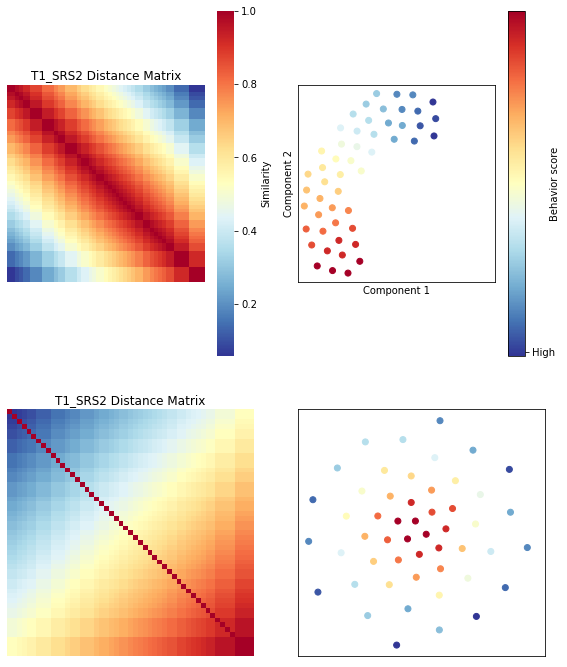

In [39]:
# T1_SRS2_Com

# Ranking the behaviour scores
T1_SRS2_Com = rankdata(dem_data['T1_SRS2_Com'])

nn4 = nn_matrix(T1_SRS2_Com, len(participants))
annak4 = annak_matrix(T1_SRS2_Com, len(participants))
plot(nn4, annak4, T1_SRS2_Com)


Loading Demographic Data (per Cohort)

In [68]:
# Demographic Data Directory

# Path to data in my PC
path_ASD_data = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\ASD_Raw_Data.xlsx'
path_Non_ASD_data = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Non_ASD_Raw_Data.xlsx'

data_ASD = pd.read_excel(path_ASD_data)
data_Non_ASD = pd.read_excel(path_Non_ASD_data)

# Participants
participants_ASD = data_ASD['ID']
participants_Non_ASD = data_Non_ASD['ID']

# Group labels (For easy plotting)
groups_ASD = data_ASD['Group']
groups_Non_ASD = data_Non_ASD['Group']


Calculating Behavioural similarity

In [71]:
# Loading most significant behaviour score

ASD_behav = data_ASD['T1_SRS2_Com']
ASD_behav_rank = rankdata(ASD_behav)
Non_ASD_behav = data_Non_ASD['T1_SRS2_Com']
Non_ASD_behav_rank = rankdata(Non_ASD_behav)

In [72]:
# Calculating distance to similarity matrix (NN)

ASD_behav_sim_nn = Adjacency(pairwise_distances(np.reshape(ASD_behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
ASD_behav_sim_nn = ASD_behav_sim_nn.distance_to_similarity()

Non_ASD_behav_sim_nn = Adjacency(pairwise_distances(np.reshape(Non_ASD_behav_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
Non_ASD_behav_sim_nn = Non_ASD_behav_sim_nn.distance_to_similarity()


In [73]:
# Number of participants

ASD_n_subs = len(participants_ASD)
Non_ASD_n_subs = len(participants_Non_ASD)


Text(0.5, 1.0, 'Behavioral similarity (NN) matrix after sorting (ASD)')

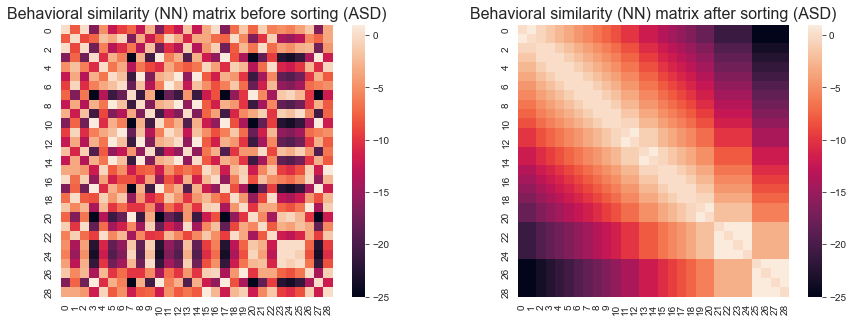

In [74]:
# Plotting Behaviour Similarity Matrix (NN, ASD)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ASD_behav_sim_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity (NN) matrix before sorting (ASD)", fontsize=16)

sns.heatmap(sort_square_mtx(ASD_behav_sim_nn.squareform(), ASD_behav),ax=ax2, square=True)
ax2.set_title("Behavioral similarity (NN) matrix after sorting (ASD)", fontsize=16)


Text(0.5, 1.0, 'Behavioral similarity (NN) matrix after sorting (Non-ASD)')

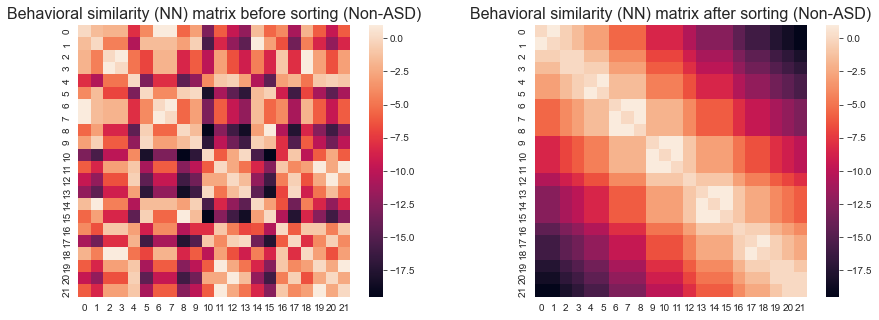

In [75]:
# Plotting Behaviour Similarity Matrix (NN, Non-ASD)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
Non_ASD_behav_sim_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity (NN) matrix before sorting (Non-ASD)", fontsize=16)

sns.heatmap(sort_square_mtx(Non_ASD_behav_sim_nn.squareform(), Non_ASD_behav), ax=ax2, square=True)
ax2.set_title("Behavioral similarity (NN) matrix after sorting (Non-ASD)", fontsize=16)


Text(0.5, 1.0, 'Behavioral similarity (AnnaK) matrix after sorting (ASD)')

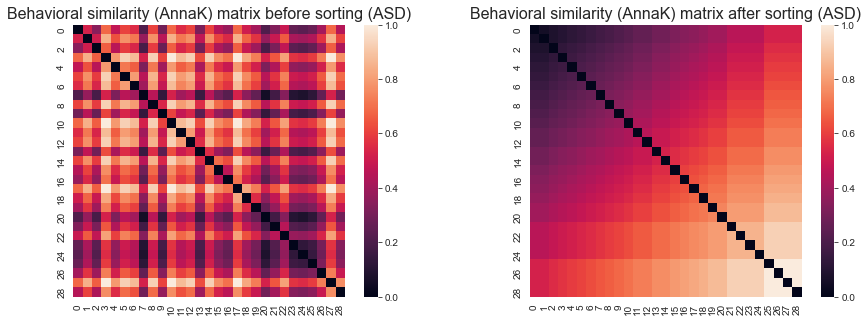

In [76]:
# Plotting Behaviour Similarity Matrix (AnnaK, ASD)

ASD_behav_sim_annak = annak_matrix(ASD_behav_rank, ASD_n_subs)

ASD_behav_sim_annak = Adjacency(ASD_behav_sim_annak, matrix_type='similarity')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ASD_behav_sim_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity (AnnaK) matrix before sorting (ASD)", fontsize=16)

sns.heatmap(sort_square_mtx(ASD_behav_sim_annak.squareform(), ASD_behav), ax = ax2, square=True)
ax2.set_title("Behavioral similarity (AnnaK) matrix after sorting (ASD)", fontsize=16)


Text(0.5, 1.0, 'Behavioral similarity (AnnaK) matrix after sorting (Non-ASD)')

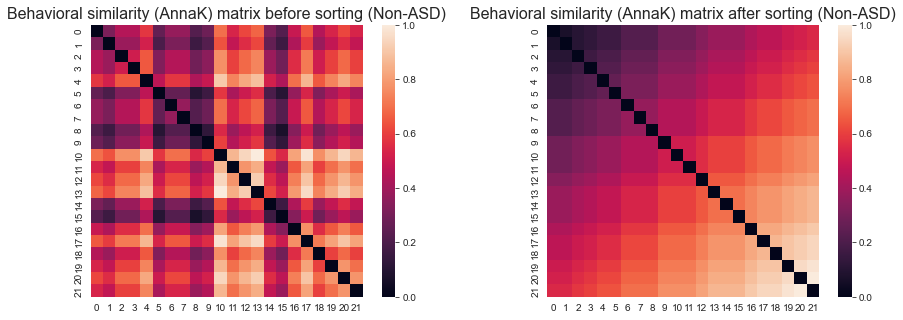

In [77]:
# Plotting Behaviour Similarity Matrix (AnnaK, Non-ASD)

Non_ASD_behav_sim_annak = annak_matrix(Non_ASD_behav_rank, Non_ASD_n_subs)

Non_ASD_behav_sim_annak = Adjacency(Non_ASD_behav_sim_annak, matrix_type='similarity')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
Non_ASD_behav_sim_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity (AnnaK) matrix before sorting (Non-ASD)", fontsize=16)

sns.heatmap(sort_square_mtx(Non_ASD_behav_sim_annak.squareform(), Non_ASD_behav), ax=ax2, square=True)
ax2.set_title("Behavioral similarity (AnnaK) matrix after sorting (Non-ASD)", fontsize=16)


IS-RS Analysis

ASD Cohort

In [78]:
# RSA for ASD Cohort

ASD_isrsa_nn_cr, ASD_isrsa_nn_p = {}, {}
ASD_isrsa_annak_cr, ASD_isrsa_annak_p = {}, {}

for node in range(len(ASD_similarity_matrices)):
    ASD_isrsa_nn = ASD_similarity_matrices[node].similarity(ASD_behav_sim_nn, metric='spearman', n_permute=10000, n_jobs=-1)
    ASD_isrsa_nn_cr[node] = ASD_isrsa_nn['correlation']
    ASD_isrsa_nn_p[node] = ASD_isrsa_nn['p']
    ASD_isrsa_annak = ASD_similarity_matrices[node].similarity(ASD_behav_sim_annak, metric='spearman', n_permute=10000, n_jobs=-1)
    ASD_isrsa_annak_cr[node] = ASD_isrsa_annak['correlation']
    ASD_isrsa_annak_p[node] = ASD_isrsa_annak['p']

ASD_isrsa_nn_corr_brain, ASD_isrsa_nn_p_brain = roi_to_brain(pd.Series(ASD_isrsa_nn_cr), mask_x), roi_to_brain(pd.Series(ASD_isrsa_nn_p), mask_x)
ASD_isrsa_annak_corr_brain, ASD_isrsa_annak_p_brain = roi_to_brain(pd.Series(ASD_isrsa_annak_cr), mask_x), roi_to_brain(pd.Series(ASD_isrsa_annak_p), mask_x)

C:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\nilearn\plotting\img_plotting.py:341: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


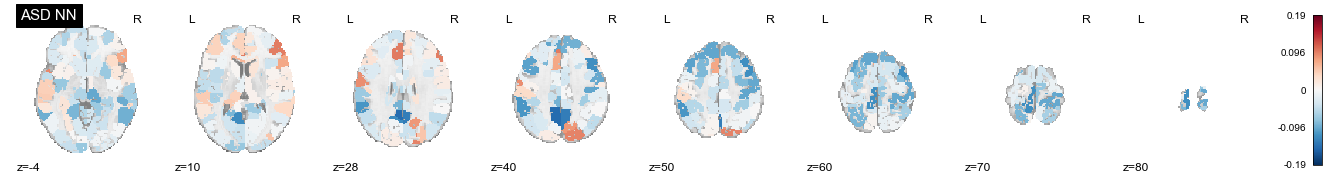

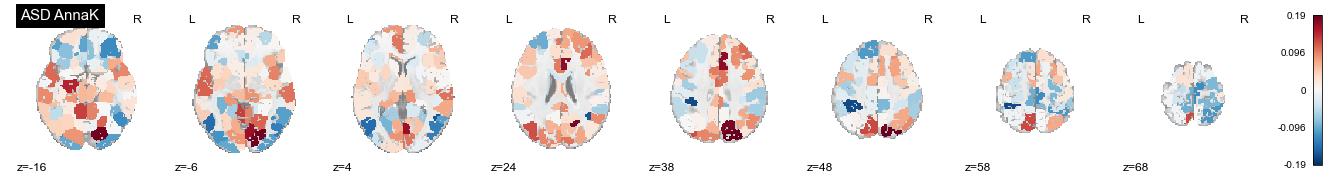

In [79]:
# Plotting without threshold

# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax1 = np.max(np.abs([list(ASD_isrsa_nn_cr.values()), list(ASD_isrsa_annak_cr.values())]))

plot_stat_map(ASD_isrsa_nn_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax1, title="ASD NN", cmap='RdBu_r')
plot_stat_map(ASD_isrsa_annak_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax1, title="ASD AnnaK", cmap='RdBu_r')


C:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\nilearn\plotting\displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


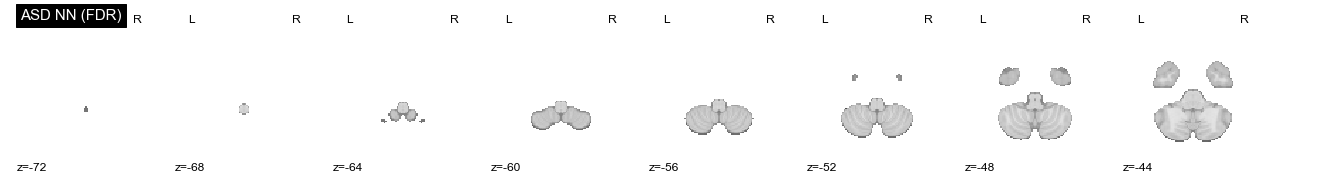

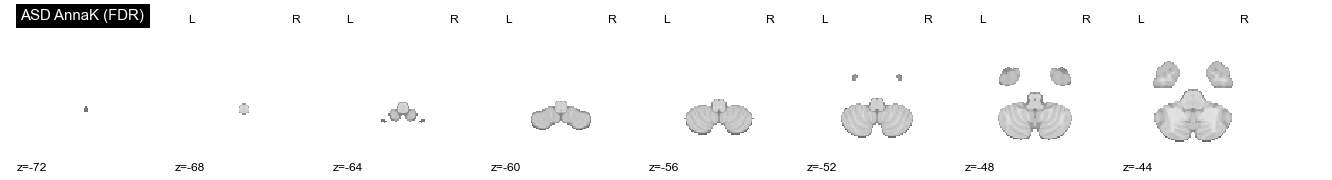

In [80]:
# Thresholding using FDR
ASD_thr_nn = threshold(ASD_isrsa_nn_corr_brain, ASD_isrsa_nn_p_brain, thr=fdr(pd.Series(ASD_isrsa_nn_p).values))
ASD_thr_annak = threshold(ASD_isrsa_annak_corr_brain, ASD_isrsa_annak_p_brain, thr=fdr(pd.Series(ASD_isrsa_annak_p).values))

plot_stat_map(ASD_thr_nn.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax1, title="ASD NN (FDR)", cmap='RdBu_r')
plot_stat_map(ASD_thr_annak.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax1, title="ASD AnnaK (FDR)", cmap='RdBu_r')


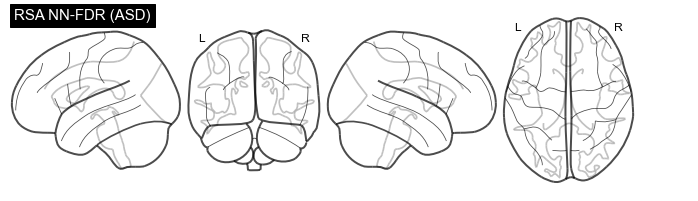

In [81]:
#Plotting ASD RSA map (NN)

plot_glass_brain(ASD_thr_nn.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA NN-FDR (ASD)')

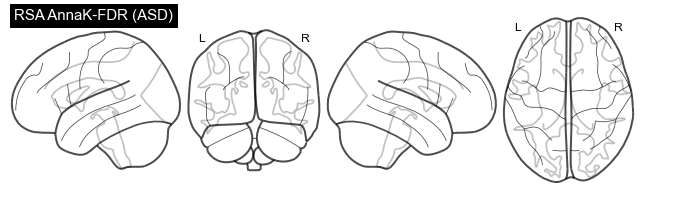

In [82]:
#Plotting ASD RSA map (AnnaK)

plot_glass_brain(ASD_thr_annak.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA AnnaK-FDR (ASD)')


Non-ASD Cohort

In [83]:
# RSA for Non-ASD Cohort

Non_ASD_isrsa_nn_cr, Non_ASD_isrsa_nn_p = {}, {}
Non_ASD_isrsa_annak_cr, Non_ASD_isrsa_annak_p = {}, {}

for node in range(len(Non_ASD_similarity_matrices)):
    Non_ASD_isrsa_nn = Non_ASD_similarity_matrices[node].similarity(Non_ASD_behav_sim_nn, metric='spearman', n_permute=10000, n_jobs=-1)
    Non_ASD_isrsa_nn_cr[node] = Non_ASD_isrsa_nn['correlation']
    Non_ASD_isrsa_nn_p[node] = Non_ASD_isrsa_nn['p']
    Non_ASD_isrsa_annak = Non_ASD_similarity_matrices[node].similarity(Non_ASD_behav_sim_annak, metric='spearman', n_permute=10000, n_jobs=-1)
    Non_ASD_isrsa_annak_cr[node] = Non_ASD_isrsa_annak['correlation']
    Non_ASD_isrsa_annak_p[node] = Non_ASD_isrsa_annak['p']

Non_ASD_isrsa_nn_corr_brain, Non_ASD_isrsa_nn_p_brain = roi_to_brain(pd.Series(Non_ASD_isrsa_nn_cr), mask_x), roi_to_brain(pd.Series(Non_ASD_isrsa_nn_p), mask_x)
Non_ASD_isrsa_annak_corr_brain, Non_ASD_isrsa_annak_p_brain = roi_to_brain(pd.Series(Non_ASD_isrsa_annak_cr), mask_x), roi_to_brain(pd.Series(Non_ASD_isrsa_annak_p), mask_x)

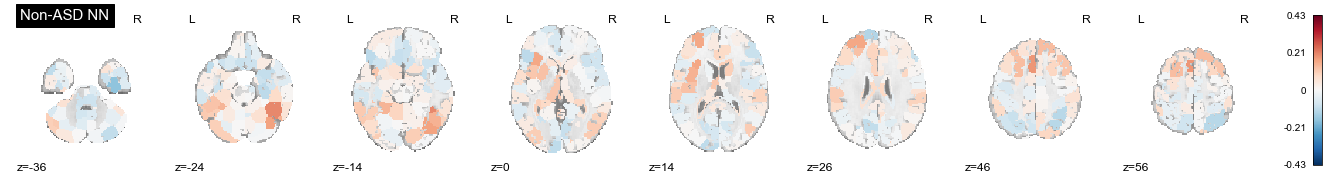

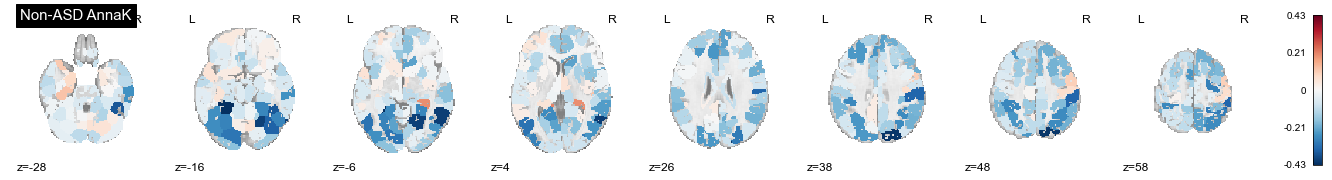

In [84]:
# Plotting without threshold

# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax2 = np.max(np.abs([list(Non_ASD_isrsa_nn_cr.values()), list(Non_ASD_isrsa_annak_cr.values())]))

plot_stat_map(Non_ASD_isrsa_nn_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax2, title="Non-ASD NN", cmap='RdBu_r')
plot_stat_map(Non_ASD_isrsa_annak_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax2, title="Non-ASD AnnaK", cmap='RdBu_r')


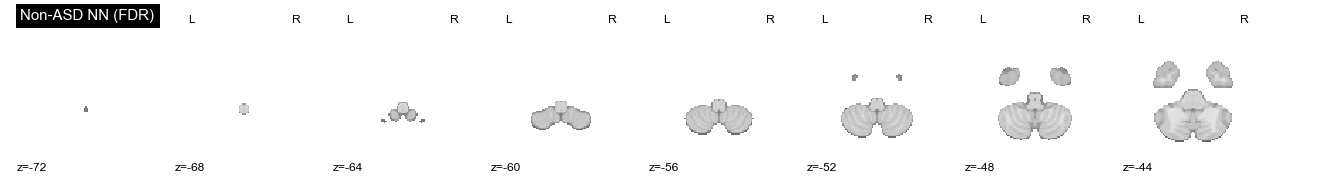

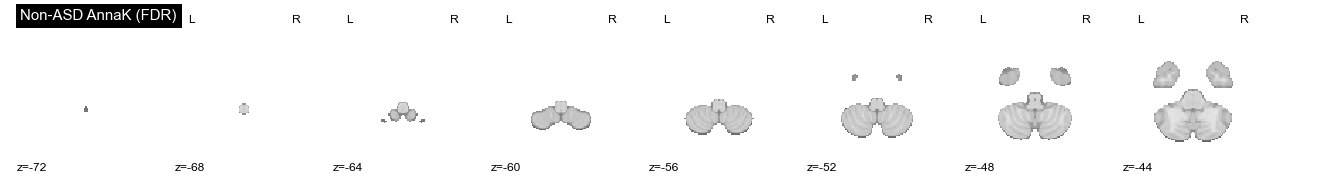

In [85]:
# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale

# Thresholding using FDR
Non_ASD_thr_nn = threshold(Non_ASD_isrsa_nn_corr_brain, Non_ASD_isrsa_nn_p_brain, thr=fdr(pd.Series(Non_ASD_isrsa_nn_p).values))
Non_ASD_thr_annak = threshold(Non_ASD_isrsa_annak_corr_brain, Non_ASD_isrsa_annak_p_brain, thr=fdr(pd.Series(Non_ASD_isrsa_annak_p).values))

plot_stat_map(Non_ASD_thr_nn.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax2, title="Non-ASD NN (FDR)", cmap='RdBu_r')
plot_stat_map(Non_ASD_thr_annak.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax2, title="Non-ASD AnnaK (FDR)", cmap='RdBu_r')


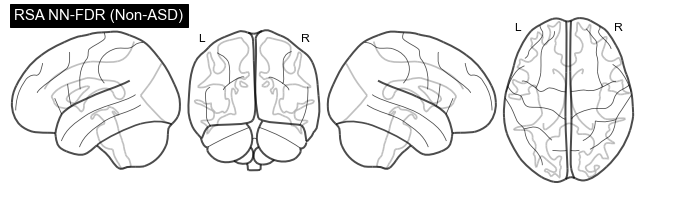

In [86]:
#Plotting ASD RSA map (NN)

plot_glass_brain(Non_ASD_thr_nn.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA NN-FDR (Non-ASD)')


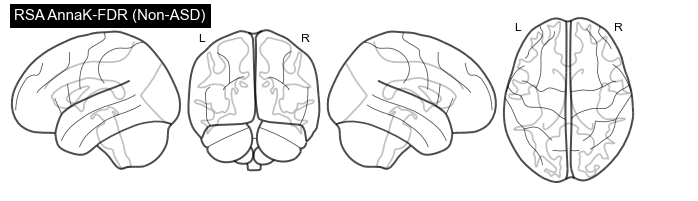

In [87]:
#Plotting ASD RSA map (AnnaK)

plot_glass_brain(Non_ASD_thr_annak.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA AnnaK-FDR (Non-ASD)')


Running IS-RSA on mean SRS2 scores for all participants

In [16]:
# Testing for normality for T1_SRS2 features

SRS2_dict = {}

for i in features_T1_SRS2:
    SRS2_dict[i] = np.array(dem_data.loc[:, i])
    _, sw_p_SRS2 = shapiro(SRS2_dict[i], str(i))
    if sw_p_SRS2 > 0.05:
        print('Values for ASD cohort follow Gaussian distribution')
    else:
        print('Values for ASD cohort do not follow Gaussian distribution')

SW test statistic for T1_SRS2_Awr is 0.9493633508682251
p-value for T1_SRS2_Awr is 0.029650647193193436
Values for ASD cohort do not follow Gaussian distribution
SW test statistic for T1_SRS2_Cog is 0.8822275400161743
p-value for T1_SRS2_Cog is 0.00011293966235825792
Values for ASD cohort do not follow Gaussian distribution
SW test statistic for T1_SRS2_Com is 0.8857200145721436
p-value for T1_SRS2_Com is 0.00014510298206005245
Values for ASD cohort do not follow Gaussian distribution
SW test statistic for T1_SRS2_Mot is 0.9143462777137756
p-value for T1_SRS2_Mot is 0.0013137803180143237
Values for ASD cohort do not follow Gaussian distribution
SW test statistic for T1_SRS2_RRB is 0.8917209506034851
p-value for T1_SRS2_RRB is 0.00022513278236147016
Values for ASD cohort do not follow Gaussian distribution


In [26]:
# Calculating mean correlation for T1_SRS2 for each participant

data_T1_SRS2 = dem_data.loc[:, features_T1_SRS2].T

# Identifying columns with std = 0
exclude_col = []

for i in data_T1_SRS2.columns:
    if np.std(data_T1_SRS2[i]) == 0:
        print(f'Index of participants with constant behaviour scores are: {i}')
        exclude_col.append(i)
    else:
        pass

# Removing columns with std = 0
for i in exclude_col:
    data_T1_SRS2 = data_T1_SRS2.drop(data_T1_SRS2.columns[[i]], axis=1)

# Calculating correlation
corr_SRS2 = np.array(data_T1_SRS2.corr(method='spearman'))
corr_SRS2 = np.where(corr_SRS2 == 1, np.nan, corr_SRS2)
print(f'Shape of the correlation matrix: {corr_SRS2.shape}')

# Calculating mean SRS2 correlation
corr_nan_SRS2 = np.where(corr_SRS2 == 1, np.nan, corr_SRS2)
corr_nan_SRS2 = np.nanmean(corr_nan_SRS2, axis=0)
corr_nan_SRS2_rank = rankdata(corr_nan_SRS2)

Index of participants with constant behaviour scores are: 33
Shape of the correlation matrix: (50, 50)


In [59]:
#Building Adjacencey Matrix for correlated SRS2 scores and best score

all_sim_nn = Adjacency(pairwise_distances(np.reshape(corr_nan_SRS2_rank, (-1, 1)), metric='euclidean'), matrix_type='distance')
all_sim_nn = all_sim_nn.distance_to_similarity()

for i in exclude_col:
    T1_SRS2_Com = rankdata(dem_data['T1_SRS2_Com'].drop([i], axis = 0))
SRS2_Com_nn = Adjacency(pairwise_distances(np.reshape(T1_SRS2_Com, (-1, 1)), metric='euclidean'), matrix_type='distance')
SRS2_Com_nn = SRS2_Com_nn.distance_to_similarity()


c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning
c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


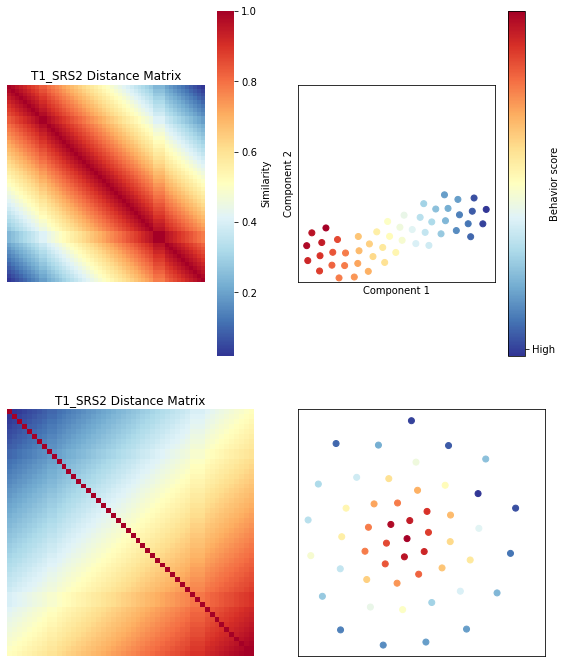

In [57]:
# Visualising the segregation using mean correlation score of SRS2

nn_SRS2 = nn_matrix(corr_nan_SRS2_rank, len(corr_nan_SRS2))
annak_SRS2 = annak_matrix(corr_nan_SRS2_rank, len(corr_nan_SRS2))
plot(nn_SRS2, annak_SRS2, corr_nan_SRS2_rank)

Text(0.5, 1.0, 'Behavioral similarity (NN) matrix after sorting')

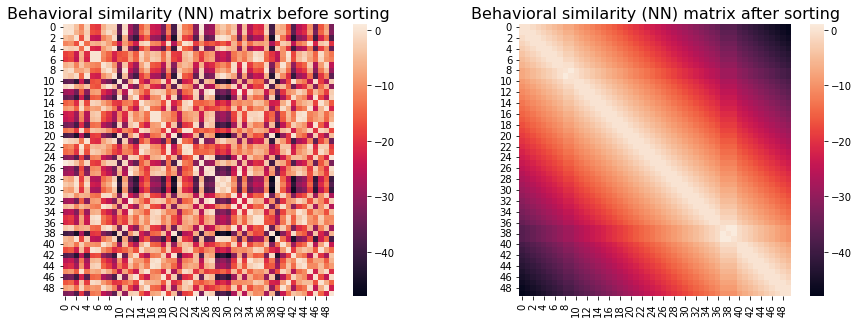

In [47]:
# Plotting Behaviour Similarity Matrix (NN) for correlated SRS2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
all_sim_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity (NN) matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(all_sim_nn.squareform(), corr_nan_SRS2), ax=ax2, square=True)
ax2.set_title("Behavioral similarity (NN) matrix after sorting", fontsize=16)

Text(0.5, 1.0, 'Behavioral similarity (NN) matrix after sorting (Com)')

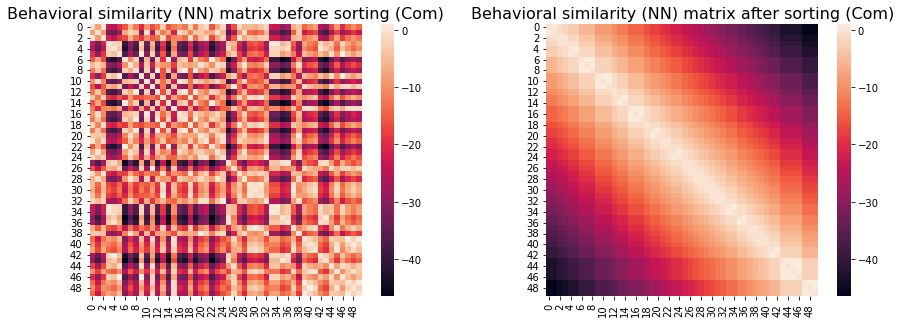

In [61]:
# Plotting Behaviour Similarity Matrix (NN) for SRS2_Com

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
SRS2_Com_nn.plot(axes=ax1)
ax1.set_title("Behavioral similarity (NN) matrix before sorting (Com)", fontsize=16)

sns.heatmap(sort_square_mtx(SRS2_Com_nn.squareform(), T1_SRS2_Com), ax=ax2, square=True)
ax2.set_title("Behavioral similarity (NN) matrix after sorting (Com)", fontsize=16)


Text(0.5, 1.0, 'Behavioral similarity (AnnaK) matrix after sorting')

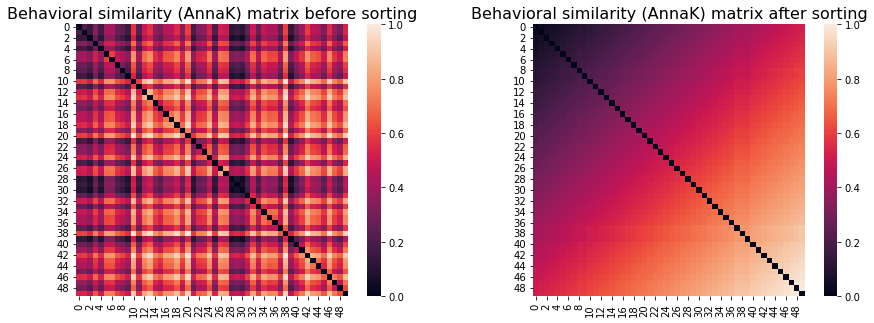

In [36]:
# Plotting Behaviour Similarity Matrix (AnnaK) for correlated SRS2

all_sim_annak = annak_matrix(corr_nan_SRS2_rank, len(corr_nan_SRS2))

all_sim_annak = Adjacency(all_sim_annak, matrix_type='similarity')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
all_sim_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity (AnnaK) matrix before sorting", fontsize=16)

sns.heatmap(sort_square_mtx(all_sim_annak.squareform(), corr_nan_SRS2), ax=ax2, square=True)
ax2.set_title("Behavioral similarity (AnnaK) matrix after sorting", fontsize=16)


Text(0.5, 1.0, 'Behavioral similarity (AnnaK) matrix after sorting (Com)')

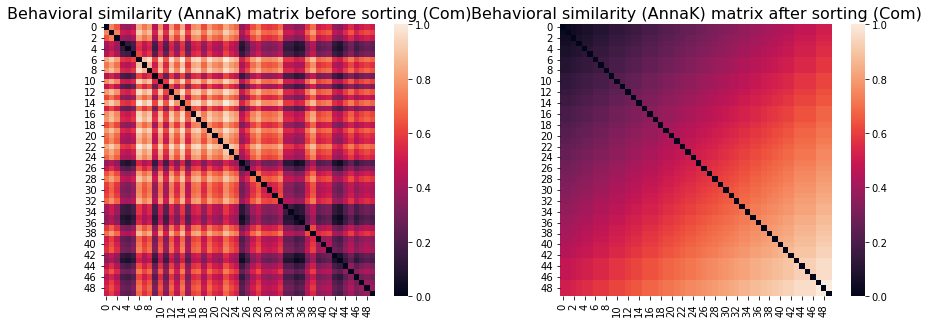

In [62]:
# Plotting Behaviour Similarity Matrix (AnnaK) for SRS2_Com

SRS2_Com_annak = annak_matrix(T1_SRS2_Com, len(dem_data['T1_SRS2_Com'])-1)

SRS2_Com_annak = Adjacency(SRS2_Com_annak, matrix_type='similarity')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
SRS2_Com_annak.plot(axes=ax1)
ax1.set_title("Behavioral similarity (AnnaK) matrix before sorting (Com)", fontsize=16)

sns.heatmap(sort_square_mtx(SRS2_Com_annak.squareform(), T1_SRS2_Com), ax=ax2, square=True)
ax2.set_title(
    "Behavioral similarity (AnnaK) matrix after sorting (Com)", fontsize=16)


In [49]:
# Running similarity check on all participants

std_3D_all = np.concatenate((std_3D_ASD, std_3D_Non_ASD), axis=0)

for i in exclude_col:
    std_3D_all = np.delete(std_3D_all, i, axis=0)
print(f'Shape of the resultant matrix: {std_3D_all.shape}')

all_n_subs, all_n_ts, all_n_nodes = std_3D_all.shape

all_similarity_matrices = []

for node in range(all_n_nodes):
    all_similarity_matrices.append(Adjacency(1 - pairwise_distances(std_3D_all[:, :, node], metric='correlation'), matrix_type='similarity'))

all_similarity_matrices = Adjacency(all_similarity_matrices)
print(all_similarity_matrices)


Shape of the resultant matrix: (50, 206, 268)
nltools.data.adjacency.Adjacency(shape=(268, 1225), square_shape=(50, 50), Y=0, is_symmetric=True,matrix_type=similarity)


In [50]:
# Running RSA using correlated SRS2 scores for all participants

all_isrsa_nn_cr, all_isrsa_nn_p = {}, {}
all_isrsa_annak_cr, all_isrsa_annak_p = {}, {}

for node in range(len(all_similarity_matrices)):
    all_isrsa_nn = all_similarity_matrices[node].similarity(all_sim_nn, metric='spearman', n_permute=10000, n_jobs=-1)
    all_isrsa_nn_cr[node] = all_isrsa_nn['correlation']
    all_isrsa_nn_p[node] = all_isrsa_nn['p']
    all_isrsa_annak = all_similarity_matrices[node].similarity(all_sim_annak, metric='spearman', n_permute=10000, n_jobs=-1)
    all_isrsa_annak_cr[node] = all_isrsa_annak['correlation']
    all_isrsa_annak_p[node] = all_isrsa_annak['p']

all_isrsa_nn_corr_brain, all_isrsa_nn_p_brain = roi_to_brain(pd.Series(all_isrsa_nn_cr), mask_x), roi_to_brain(pd.Series(all_isrsa_nn_p), mask_x)
all_isrsa_annak_corr_brain, all_isrsa_annak_p_brain = roi_to_brain(pd.Series(all_isrsa_annak_cr), mask_x), roi_to_brain(pd.Series(all_isrsa_annak_p), mask_x)


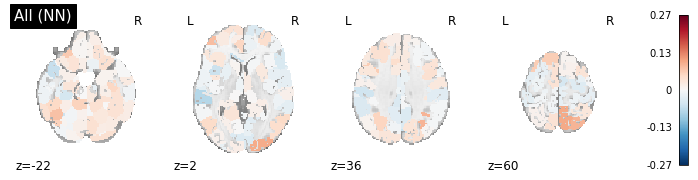

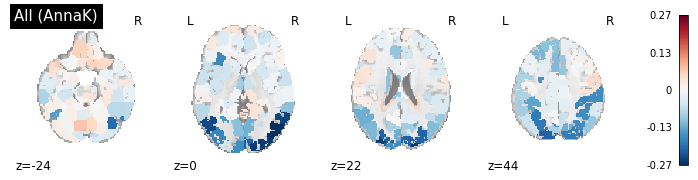

In [74]:
# Plotting without threshold

# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax3 = np.max(np.abs([list(all_isrsa_nn_cr.values()), list(all_isrsa_annak_cr.values())]))

plot_stat_map(all_isrsa_nn_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax3, title="All (NN)", cmap='RdBu_r')
plot_stat_map(all_isrsa_annak_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax3, title="All (AnnaK)", cmap='RdBu_r')


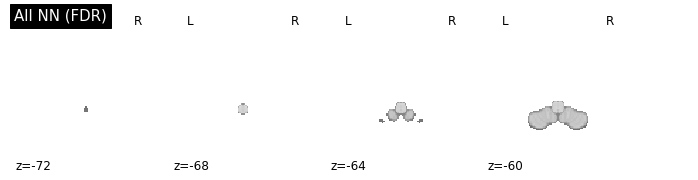

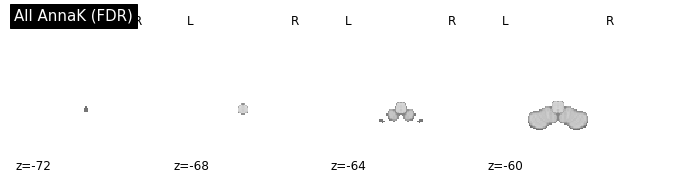

In [77]:
# Thresholding using FDR

all_thr_nn = threshold(all_isrsa_nn_corr_brain, all_isrsa_nn_p_brain, thr=fdr(pd.Series(all_isrsa_nn_p).values))
all_thr_annak = threshold(all_isrsa_annak_corr_brain, all_isrsa_annak_p_brain, thr=fdr(pd.Series(all_isrsa_annak_p).values))

plot_stat_map(all_thr_nn.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax3, title="All NN (FDR)", cmap='RdBu_r')
plot_stat_map(all_thr_annak.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax3, title="All AnnaK (FDR)", cmap='RdBu_r')


In [78]:
print (f'FDR Threshold for correlated SRS2 scores: {fdr(pd.Series(all_isrsa_nn_p).values)}')

FDR Threshold for correlated SRS2 scores: -1


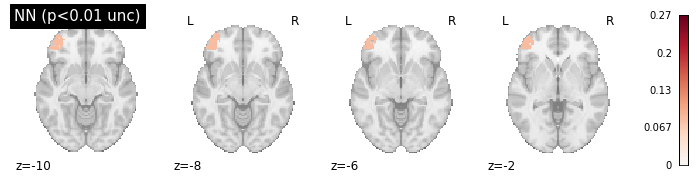

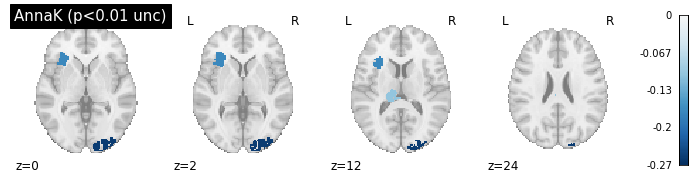

In [81]:
# Thresholding using FDR, thr = 0.01

all_thr_set_nn = threshold(all_isrsa_nn_corr_brain, all_isrsa_nn_p_brain, thr=0.01)
all_thr_set_annak = threshold(all_isrsa_annak_corr_brain, all_isrsa_annak_p_brain, thr=0.01)

plot_stat_map(all_thr_set_nn.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax3, title="NN (p<0.01 unc)", cmap='RdBu_r')
plot_stat_map(all_thr_set_annak.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax3, title="AnnaK (p<0.01 unc)", cmap='RdBu_r')


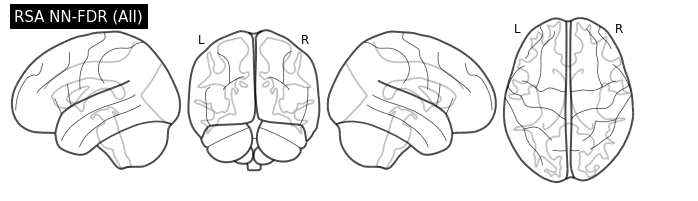

In [53]:
#Plotting ASD RSA map (NN)

plot_glass_brain(all_thr_nn.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA NN-FDR (All)')


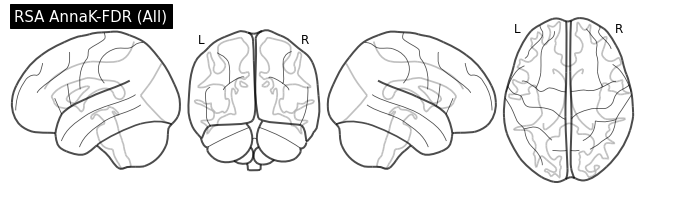

In [54]:
#Plotting ASD RSA map (Annak)

plot_glass_brain(all_thr_annak.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA AnnaK-FDR (All)')

In [63]:
# Running RSA using SRS2_com scores for all participants

com_isrsa_nn_cr, com_isrsa_nn_p = {}, {}
com_isrsa_annak_cr, com_isrsa_annak_p = {}, {}

for node in range(len(all_similarity_matrices)):
    com_isrsa_nn = all_similarity_matrices[node].similarity(SRS2_Com_nn, metric='spearman', n_permute=10000, n_jobs=-1)
    com_isrsa_nn_cr[node] = com_isrsa_nn['correlation']
    com_isrsa_nn_p[node] = com_isrsa_nn['p']
    com_isrsa_annak = all_similarity_matrices[node].similarity(SRS2_Com_annak, metric='spearman', n_permute=10000, n_jobs=-1)
    com_isrsa_annak_cr[node] = com_isrsa_annak['correlation']
    com_isrsa_annak_p[node] = com_isrsa_annak['p']

com_isrsa_nn_corr_brain, com_isrsa_nn_p_brain = roi_to_brain(pd.Series(com_isrsa_nn_cr), mask_x), roi_to_brain(pd.Series(com_isrsa_nn_p), mask_x)
com_isrsa_annak_corr_brain, com_isrsa_annak_p_brain = roi_to_brain(pd.Series(com_isrsa_annak_cr), mask_x), roi_to_brain(pd.Series(com_isrsa_annak_p), mask_x)

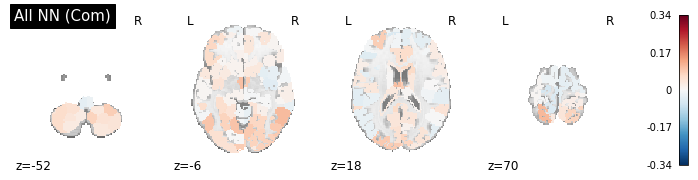

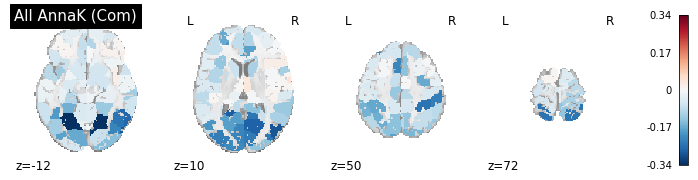

In [64]:
# Plotting without threshold (Com)

# Find the max absolute magnitude r_val across both sets of results so we can plot using the same colorscale
vmax4 = np.max(np.abs([list(com_isrsa_nn_cr.values()), list(com_isrsa_annak_cr.values())]))

plot_stat_map(com_isrsa_nn_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax4, title="All NN (Com)", cmap='RdBu_r')
plot_stat_map(com_isrsa_annak_corr_brain.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax4, title="All AnnaK (Com)", cmap='RdBu_r')

c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\nilearn\plotting\displays.py:880: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


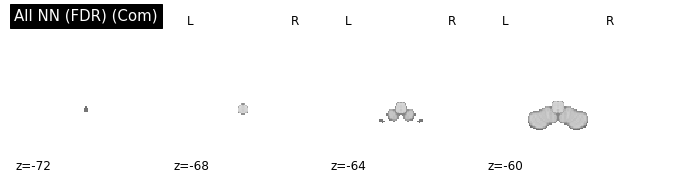

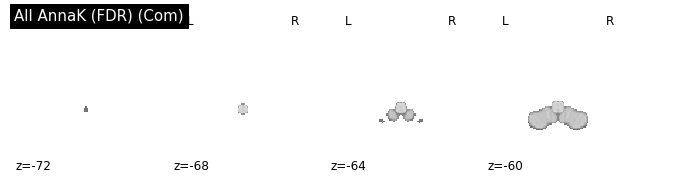

In [84]:
# Thresholding using FDR (Com)

com_thr_nn = threshold(com_isrsa_nn_corr_brain, com_isrsa_nn_p_brain, thr=fdr(pd.Series(com_isrsa_nn_p).values))
com_thr_annak = threshold(com_isrsa_annak_corr_brain, com_isrsa_annak_p_brain, thr=fdr(pd.Series(com_isrsa_annak_p).values))

plot_stat_map(com_thr_nn.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax4, title="All NN (FDR) (Com)", cmap='RdBu_r')
plot_stat_map(com_thr_annak.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax4, title="All AnnaK (FDR) (Com)", cmap='RdBu_r')

In [71]:
print(f'FDR Threshold for SRS2_Com scores: {fdr(pd.Series(com_isrsa_nn_p).values)}')


FDR Threshold for SRS2_Com scores: -1


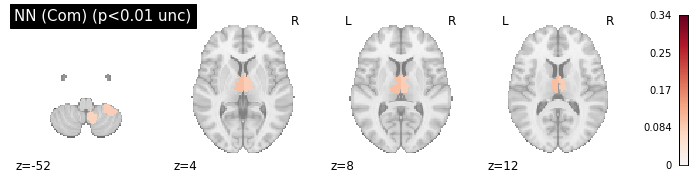

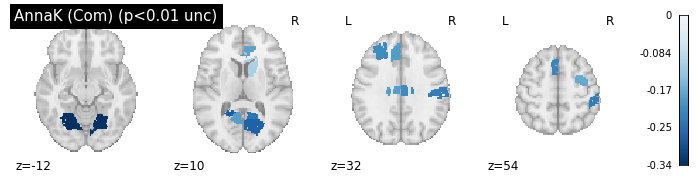

In [85]:
# Thresholding using FDR (Com), thr = 0.01

com_thr_set_nn = threshold(com_isrsa_nn_corr_brain, com_isrsa_nn_p_brain, thr=0.01)
com_thr_set_annak = threshold(com_isrsa_annak_corr_brain, com_isrsa_annak_p_brain, thr=0.01)

plot_stat_map(com_thr_set_nn.to_nifti(), display_mode='z', cut_coords=4, vmax=vmax4, title="NN (Com) (p<0.01 unc)", cmap='RdBu_r')
plot_stat_map(com_thr_set_annak.to_nifti(), display_mode='z', cut_coords=4,vmax=vmax4, title="AnnaK (Com) (p<0.01 unc)", cmap='RdBu_r')


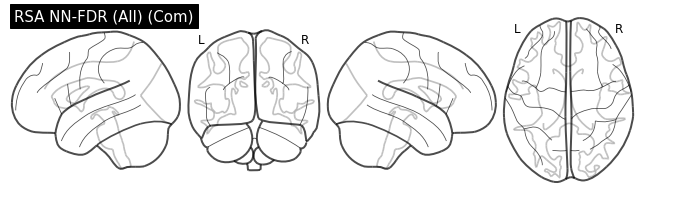

In [66]:
#Plotting ASD RSA map (NN) (Com)

plot_glass_brain(com_thr_nn.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA NN-FDR (All) (Com)')

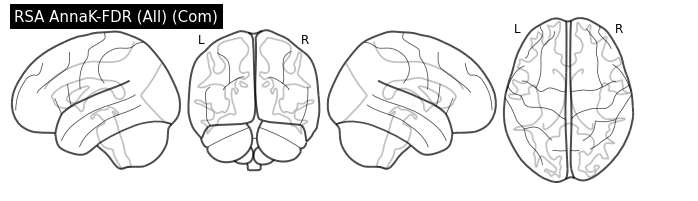

In [67]:
#Plotting ASD RSA map (Annak) (Com)

plot_glass_brain(com_thr_annak.to_nifti(), colorbar=True, plot_abs=False, display_mode='lyrz', cmap='RdBu_r', title='RSA AnnaK-FDR (All) (Com)')

Exporting IS-RSA Results

In [88]:
# Saving IS-RSA values to a CSV file

# For ASD Cohort
ASD_rsa = pd.DataFrame()
ASD_rsa['NN_Corr'] = ASD_isrsa_nn_cr.values()
ASD_rsa['NN_p'] = ASD_isrsa_nn_p.values()
ASD_rsa['AnnaK_Corr'] = ASD_isrsa_annak_cr.values()
ASD_rsa['AnnaK_p'] = ASD_isrsa_annak_p.values()
ASD_rsa.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\Run_2_ASD_RSA_Results.csv', index=False)

# For Non-ASD Cohort
Non_ASD_rsa = pd.DataFrame()
Non_ASD_rsa['NN_Corr'] = Non_ASD_isrsa_nn_cr.values()
Non_ASD_rsa['NN_p'] = Non_ASD_isrsa_nn_p.values()
Non_ASD_rsa['AnnaK_Corr'] = Non_ASD_isrsa_annak_cr.values()
Non_ASD_rsa['AnnaK_p'] = Non_ASD_isrsa_annak_p.values()
Non_ASD_rsa.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Run_2_Non_ASD_RSA_Results.csv', index=False)


In [89]:
# Exporting nifti file (RSA)

ASD_RSA_nn_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\Run_2_ASD_RSA_nn_per_ROI.nii.gz'
ASD_RSA_annak_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\Run_2_ASD_RSA_annak_per_ROI.nii.gz'
Non_ASD_RSA_nn_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Run_2_Non_ASD_RSA_nn_per_ROI.nii.gz'
Non_ASD_RSA_annak_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Run_2_Non_ASD_RSA_annak_per_ROI.nii.gz'

ASD_thr_nn.write(ASD_RSA_nn_file)
Non_ASD_thr_nn.write(Non_ASD_RSA_nn_file)
ASD_thr_annak.write(ASD_RSA_annak_file)
Non_ASD_thr_annak.write(Non_ASD_RSA_annak_file)


In [68]:
# Saving Common IS-RSA values to a CSV file

# For correlated SRS2
all_rsa = pd.DataFrame()
all_rsa['NN_Corr'] = all_isrsa_nn_cr.values()
all_rsa['NN_p'] = all_isrsa_nn_p.values()
all_rsa['AnnaK_Corr'] = all_isrsa_annak_cr.values()
all_rsa['AnnaK_p'] = all_isrsa_annak_p.values()
all_rsa.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\All_RSA_Results.csv', index=False)

# For SRS2_Com
com_rsa = pd.DataFrame()
com_rsa['NN_Corr'] = com_isrsa_nn_cr.values()
com_rsa['NN_p'] = com_isrsa_nn_p.values()
com_rsa['AnnaK_Corr'] = com_isrsa_annak_cr.values()
com_rsa['AnnaK_p'] = com_isrsa_annak_p.values()
com_rsa.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\Com_RSA_Results.csv', index=False)


In [69]:
# Exporting nifti file (RSA) (all participants)

all_RSA_nn_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\All_RSA_nn_per_ROI.nii.gz'
all_RSA_annak_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\All_RSA_annak_per_ROI.nii.gz'
com_RSA_nn_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\Com_RSA_nn_per_ROI.nii.gz'
com_RSA_annak_file = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\Com_RSA_annak_per_ROI.nii.gz'

all_thr_nn.write(all_RSA_nn_file)
com_thr_nn.write(com_RSA_nn_file)
all_thr_annak.write(all_RSA_annak_file)
com_thr_annak.write(com_RSA_annak_file)